In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#sklearn
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance

from sklearn.neighbors import KNeighborsClassifier

#json
import json

<h3>Functions</h3>

In [2]:
def plot_grid_search_results(grid_results, grid_best_params, grid_best_score):
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (12,18)) #figsize = (13,30)
    
    ax1.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_f1'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_f1'],
                 ecolor = 'orange')
    ax1.set_xlabel('n_neigbors')
    ax1.set_ylabel('f1')
    ax1.set_title('Classification F1')
    
    ax2.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_recall'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_recall'],
                 ecolor = 'orange')
    ax2.set_xlabel('n_neigbors') 
    ax2.set_ylabel('recall')
    ax2.set_title('Classification Recall')
    
    ax3.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_roc_auc'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_roc_auc'],
                 ecolor = 'orange')
    ax3.plot([grid_best_params['n_neighbors']], [grid_best_score], 
              marker='.', 
              markeredgewidth=3,
              c='r')
    ax3.annotate('best k', xy = (grid_best_params['n_neighbors'], grid_best_score),
                 xytext = (grid_best_params['n_neighbors'] + 1, grid_best_score + 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.01))
    ax3.set_xlabel('n_neigbors') 
    ax3.set_ylabel('roc auc')
    ax3.set_title('Classification Roc Auc')

    fig.tight_layout()
    plt.show()

In [3]:
def results_permutation_importance(res, attr):
    
    # get importance
    importance = res.importances_mean
    
    # summarize feature importance
    feature_importances = []
    for col, imp in zip(attr, importance):
        feature_importances.append((col, imp))
  
    sorted_feature_importances = sorted(feature_importances, key=lambda tup:(-tup[1], tup[0]))
    
    return sorted_feature_importances

In [4]:
def plot_permutation_importance(res, attr, tit):
    
    fig, ax = plt.subplots(figsize = (12,8)) 
    
    feature_names = np.r_[attr]
    
    importance = res.importances_mean
    sorted_idx = res.importances_mean.argsort()
    
    y_ticks = np.arange(0, len(feature_names))
    ax.barh(y_ticks, importance[sorted_idx], height=0.7, color = "#CC6600")
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(tit)
    
    fig.tight_layout()
    plt.show()

In [5]:
def draw_confusion_matrix(Clf, X, y):
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(Clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [6]:
def draw_roc_curve(Y_test, Y_pred, diz, k):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred, average = None)
    
    diz[k] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc": roc_auc}
    
    ax.plot(fpr, tpr, color = "#994D00", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model')
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", fontsize=14, frameon=False)
    
    fig.tight_layout()
    plt.show()

<h3>Onehot encoding</h3>

In [7]:
df = pd.read_csv("Numerical_NON_NORMALIZED_Train_HR_Employee_Attrition.csv")

In [8]:
df

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,0,1,0,9,4,2,0,3,...,17,3,0,2,2,8,7,156.61,0.39,2
1,36,0,0,1,0,1,1,2,0,3,...,14,3,1,3,3,1,8,157.94,0.41,2
2,25,0,0,0,1,16,3,3,0,3,...,25,3,1,4,3,1,5,448.06,0.70,3
3,33,0,0,1,0,5,4,2,0,3,...,14,2,0,1,3,3,7,271.91,0.84,2
4,31,0,0,1,0,9,2,3,1,3,...,12,3,0,2,3,10,2,106.37,0.21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,38,1,0,1,0,12,3,3,1,4,...,15,4,0,2,3,10,0,282.47,0.79,3
879,37,0,0,1,0,16,2,4,1,4,...,13,2,2,3,2,17,0,76.29,0.71,3
880,33,1,1,0,0,6,4,2,1,1,...,18,2,0,2,2,11,7,272.88,0.75,2
881,33,0,0,1,0,4,1,3,0,2,...,12,1,0,2,4,3,2,208.67,0.86,2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     883 non-null    int64  
 1   Attrition                               883 non-null    int64  
 2   BusinessTravel_Non-Travel               883 non-null    int64  
 3   BusinessTravel_Travel_Rarely            883 non-null    int64  
 4   BusinessTravel_Travel_Frequently        883 non-null    int64  
 5   DistanceFromHome                        883 non-null    int64  
 6   Education                               883 non-null    int64  
 7   EnvironmentSatisfaction                 883 non-null    int64  
 8   Gender                                  883 non-null    int64  
 9   JobInvolvement                          883 non-null    int64  
 10  JobLevel                                883 non-null    int64 

In [10]:
df.describe()

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,...,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,36.554926,0.173273,0.101925,0.733862,0.164213,9.201586,2.886750,2.684032,0.388448,2.750849,...,15.207248,2.716874,0.793884,2.665912,2.767837,6.326161,3.919592,234.245832,0.463918,2.322763
std,8.266129,0.378698,0.302721,0.442188,0.370679,8.241818,1.008285,1.092567,0.487674,0.729354,...,3.589332,1.078137,0.865362,1.187828,0.721713,4.523567,3.435392,130.196652,0.319880,0.535595
min,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,26.040000,0.000000,1.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,130.630000,0.130000,2.000000
50%,35.000000,0.000000,0.000000,1.000000,0.000000,7.000000,3.000000,3.000000,0.000000,3.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,212.280000,0.530000,2.000000
75%,42.000000,0.000000,0.000000,1.000000,0.000000,14.000000,4.000000,4.000000,1.000000,3.000000,...,18.000000,4.000000,1.000000,3.000000,3.000000,9.000000,7.000000,309.905000,0.760000,3.000000
max,60.000000,1.000000,1.000000,1.000000,1.000000,29.000000,5.000000,4.000000,1.000000,4.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,16.000000,590.980000,0.950000,4.000000


<h3>Divide into features and target</h3>

In [12]:
attributes = [col for col in df.columns if col != 'Attrition']

X = df[attributes].values
y = df['Attrition']

<h3>Stratified Holdout combined with Stratified K-fold Cross Validation</h3>

In [13]:
scaler_dict = dict()

<h4>MinMaxScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5932702070566052
Best parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=7, p=1)

Best k ('n_neighbors'): 7

Plots of the metrics used by the grid search


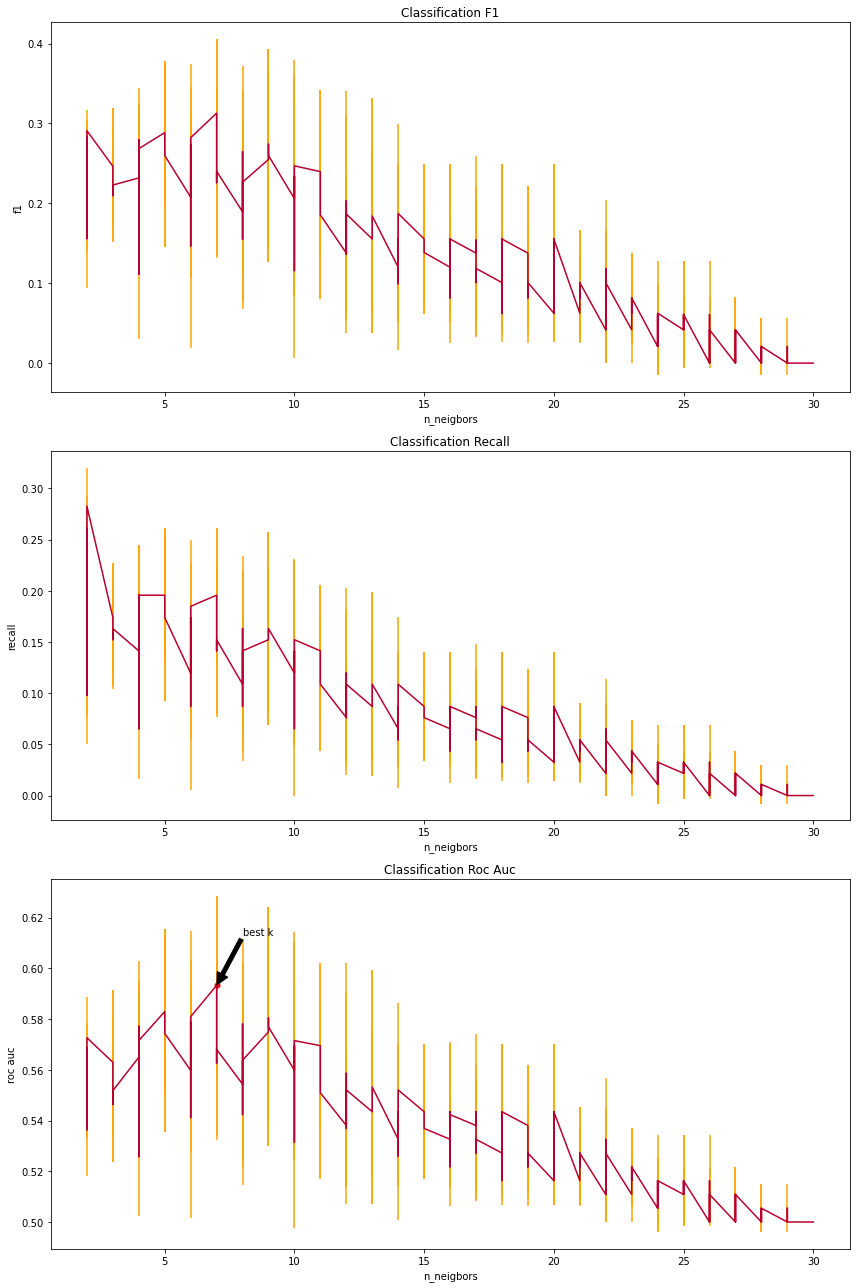



Permutation importances of the training set

OverTime                                           0.019823
JobRole_Laboratory_Technician                      0.013683
EnvironmentSatisfaction                            0.010579
JobRole_Manufacturing_Director                     0.008004
DistanceFromHome                                   0.006369
JobRole_Research_Scientist                         0.004654
JobSatisfaction                                    0.004616
StockOptionLevel                                   0.004459
NumCompaniesWorked                                 0.003665
YearsInCurrentRole                                 0.003610
JobRole_Research_Director                          0.002837
JobRole_Human_Resources                            0.002495
BusinessTravel_Non-Travel                          0.001971
JobRole_Sales_Representative                       0.001782
JobRole_Healthcare_Representative                  0.000603
JobRole_Manager_Human_Resources                    0.

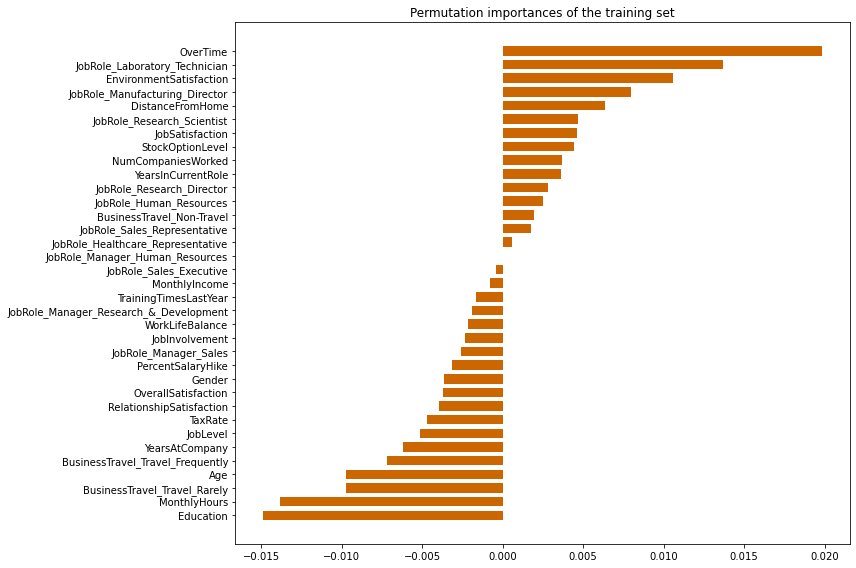



Predictions

Permutation importances of the test set

OverTime                                           0.050403
YearsInCurrentRole                                 0.046173
StockOptionLevel                                   0.040567
EnvironmentSatisfaction                            0.035576
JobSatisfaction                                    0.035366
RelationshipSatisfaction                           0.032155
JobRole_Sales_Executive                            0.029743
JobLevel                                           0.029033
JobInvolvement                                     0.026663
JobRole_Laboratory_Technician                      0.024778
TrainingTimesLastYear                              0.023466
MonthlyIncome                                      0.023149
Age                                                0.013350
TaxRate                                            0.013238
YearsAtCompany                                     0.012275
PercentSalaryHike                           

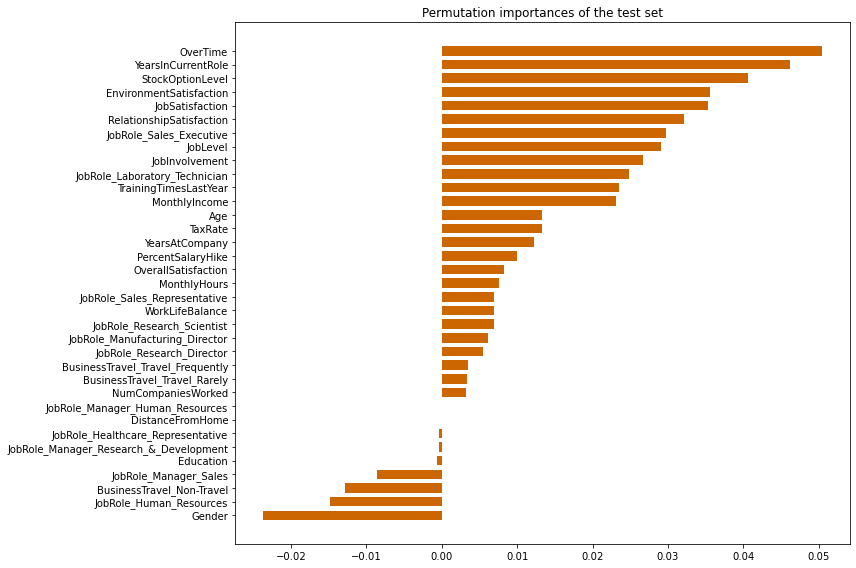



Confusion matrix


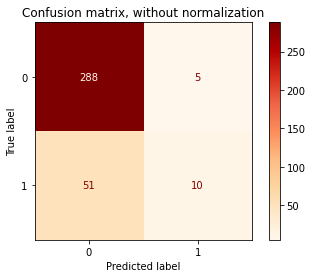

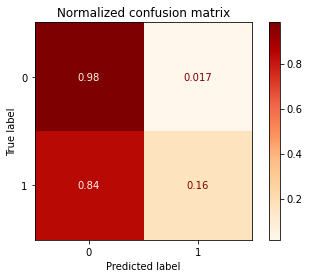


Classification report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       293
           1       0.67      0.16      0.26        61

    accuracy                           0.84       354
   macro avg       0.76      0.57      0.59       354
weighted avg       0.82      0.84      0.80       354


Metrics

Accuracy 0.8418079096045198
F1-score [0.91139241 0.26315789]
Precision [0.84955752 0.66666667]
Recall [0.98293515 0.16393443]
Roc_auc 0.5734347899065629


Roc curve



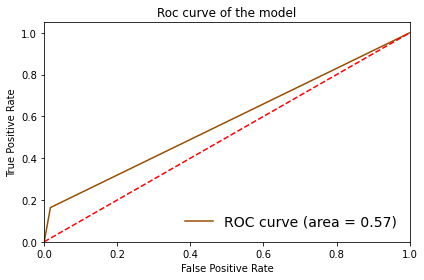


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5965206403736792
Best parameters: {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


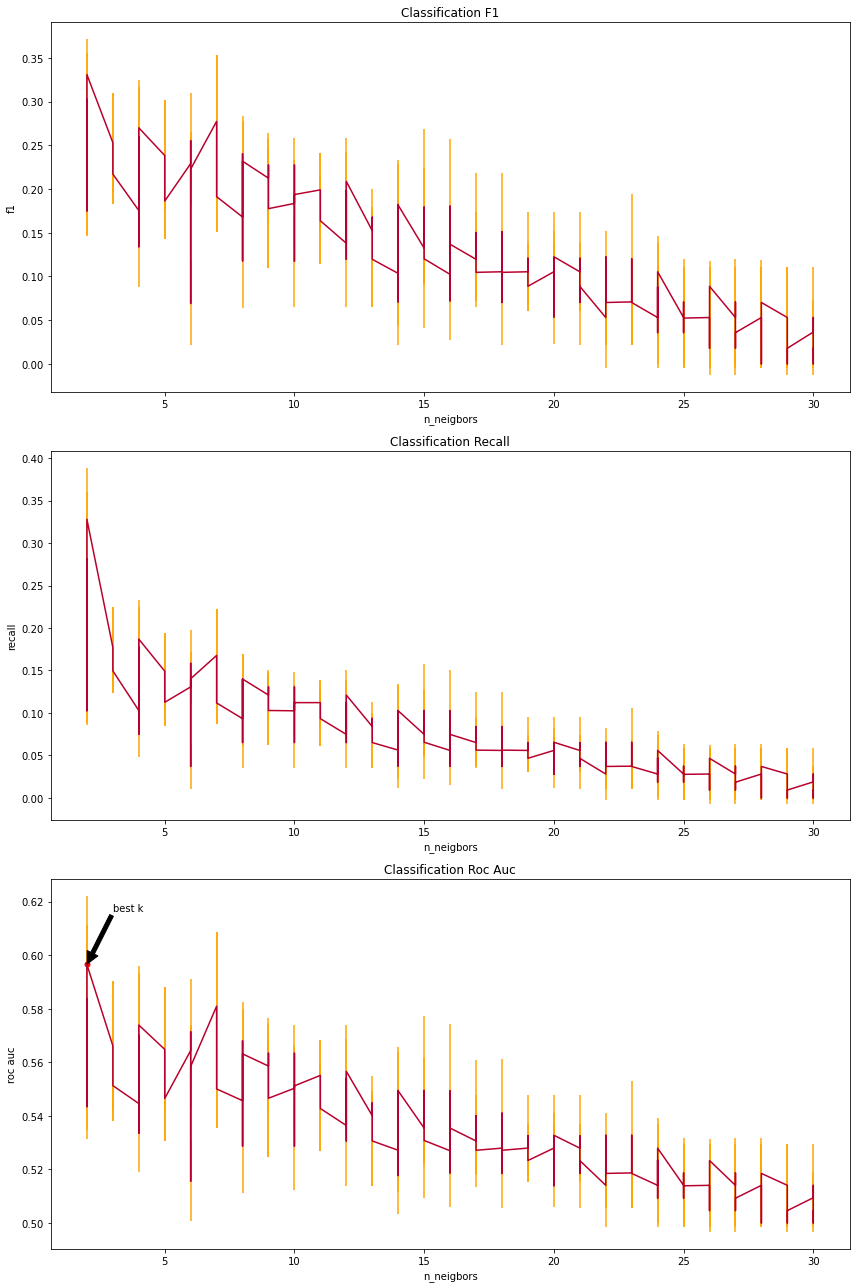



Permutation importances of the training set

Gender                                             0.012819
OverTime                                           0.011558
StockOptionLevel                                   0.004602
JobSatisfaction                                    0.002150
RelationshipSatisfaction                           0.002111
EnvironmentSatisfaction                            0.000060
NumCompaniesWorked                                 0.000004
WorkLifeBalance                                    0.000002
TaxRate                                            0.000002
Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
JobInvolvement                                     0.

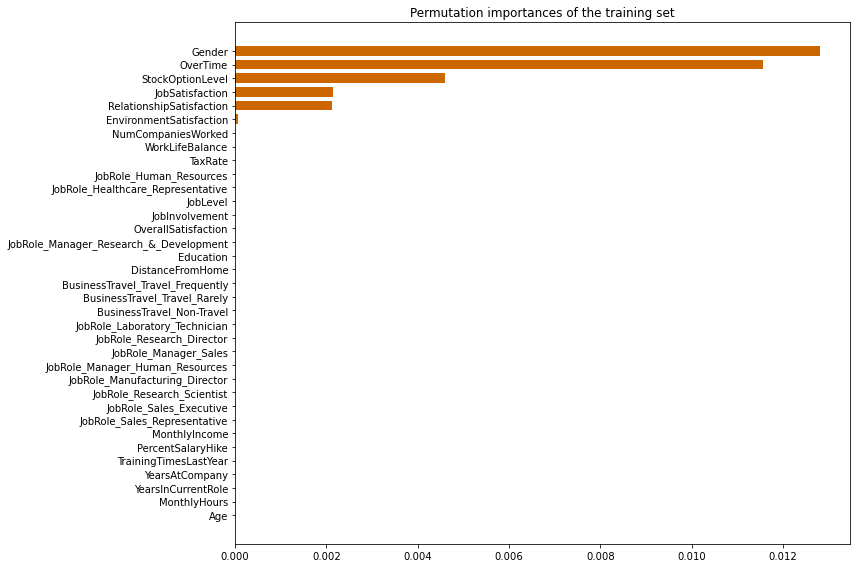



Predictions

Permutation importances of the test set

JobSatisfaction                                    0.050199
EnvironmentSatisfaction                            0.046139
OverTime                                           0.043444
JobRole_Sales_Representative                       0.039046
JobRole_Research_Scientist                         0.029462
Gender                                             0.027328
BusinessTravel_Travel_Rarely                       0.026052
WorkLifeBalance                                    0.025630
JobRole_Laboratory_Technician                      0.022826
PercentSalaryHike                                  0.021784
Age                                                0.021312
StockOptionLevel                                   0.019223
BusinessTravel_Travel_Frequently                   0.016741
NumCompaniesWorked                                 0.015222
JobRole_Manufacturing_Director                     0.014463
JobRole_Sales_Executive                     

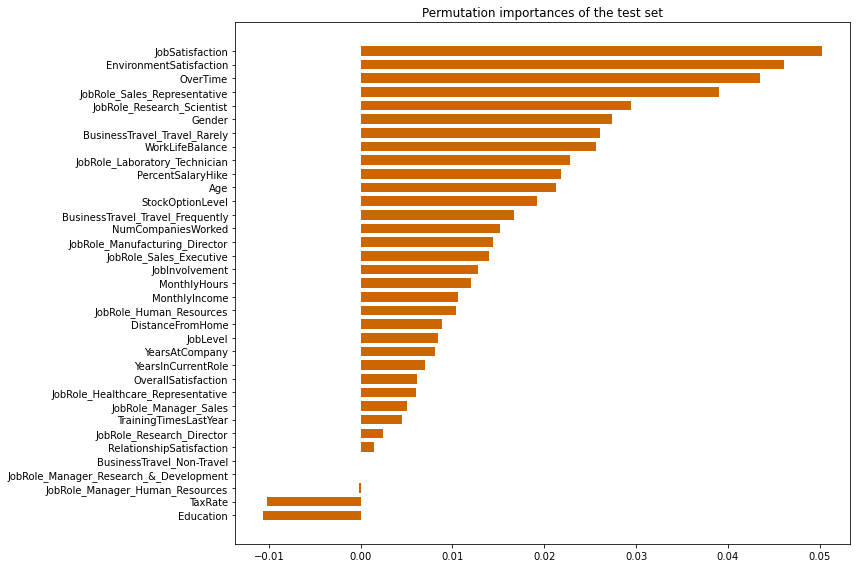



Confusion matrix


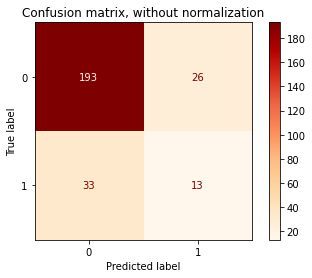

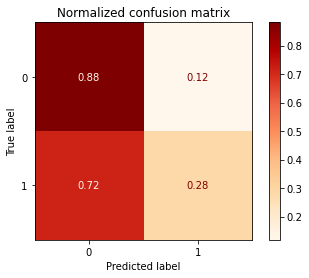


Classification report
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       219
           1       0.33      0.28      0.31        46

    accuracy                           0.78       265
   macro avg       0.59      0.58      0.59       265
weighted avg       0.76      0.78      0.77       265


Metrics

Accuracy 0.7773584905660378
F1-score [0.86741573 0.30588235]
Precision [0.8539823  0.33333333]
Recall [0.88127854 0.2826087 ]
Roc_auc 0.5819436172324797


Roc curve



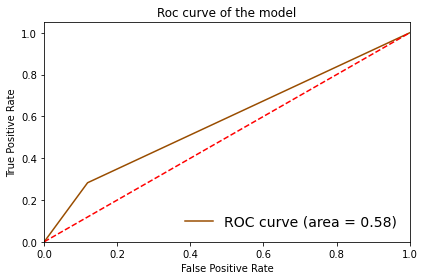


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6189681838267787
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


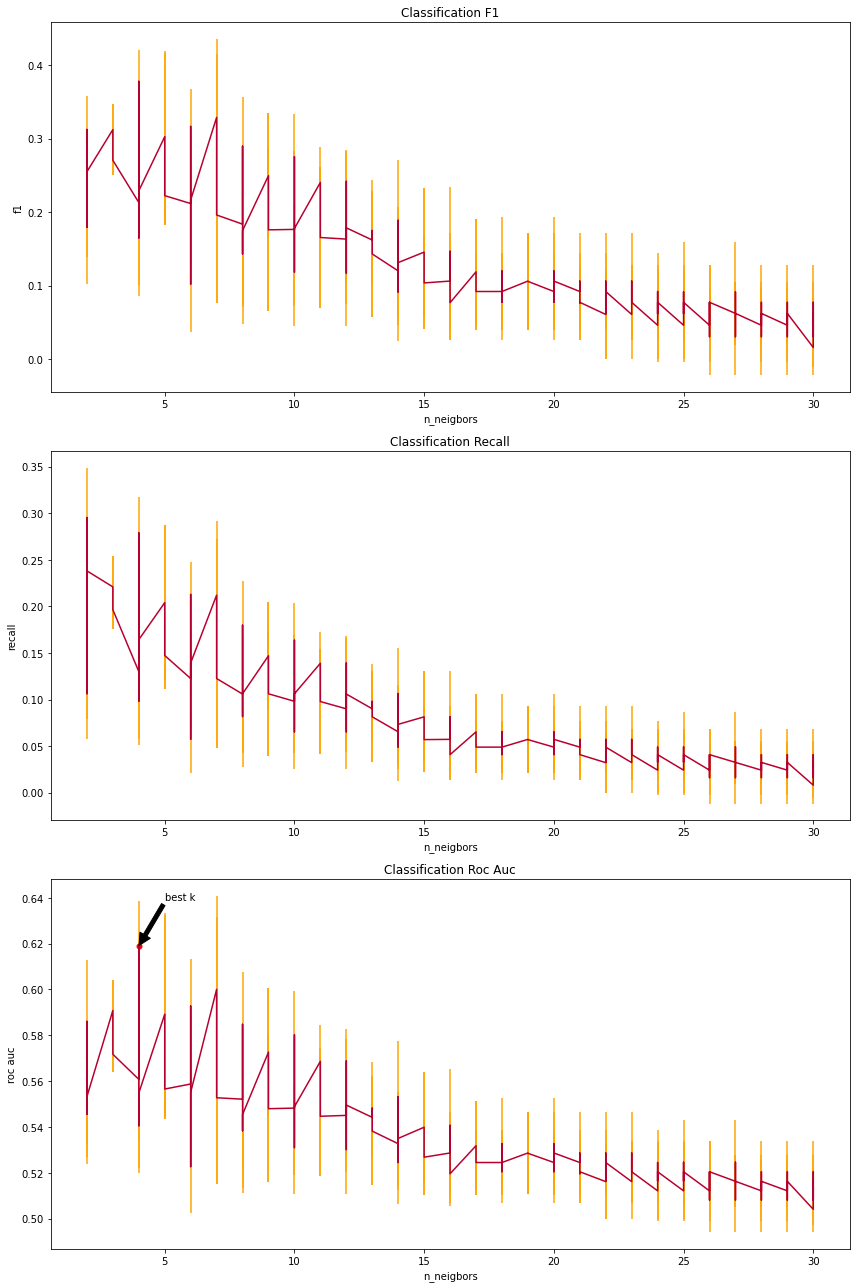



Permutation importances of the training set

Gender                                             0.000058
OverTime                                           0.000018
Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Human_Resources                    0.000000
JobRole_Manager_Research_&_Development             0.

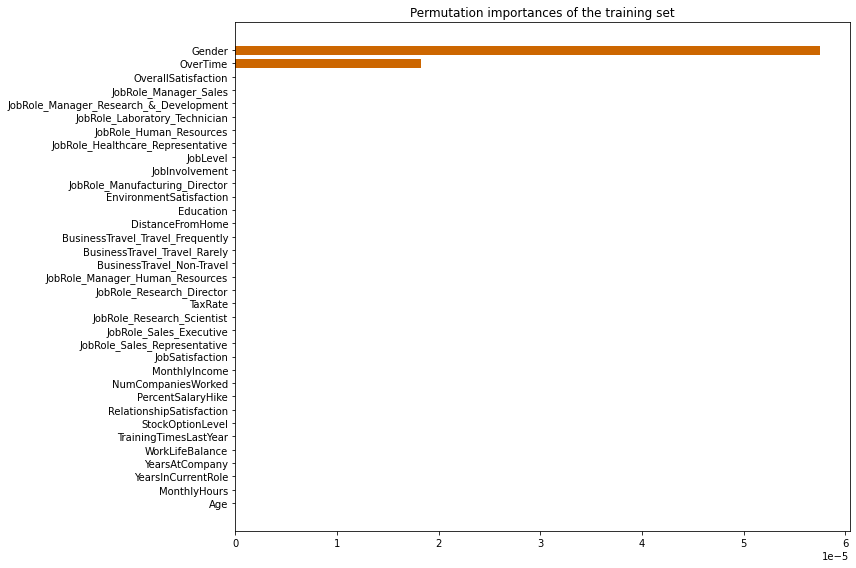



Predictions

Permutation importances of the test set

OverTime                                           0.055535
JobSatisfaction                                    0.048100
JobRole_Sales_Representative                       0.047393
WorkLifeBalance                                    0.035141
OverallSatisfaction                                0.033241
JobRole_Manufacturing_Director                     0.024635
JobRole_Research_Scientist                         0.023210
JobLevel                                           0.017278
JobRole_Human_Resources                            0.016637
RelationshipSatisfaction                           0.014715
DistanceFromHome                                   0.012583
EnvironmentSatisfaction                            0.011843
YearsInCurrentRole                                 0.011335
JobRole_Manager_Sales                              0.008374
Age                                                0.007634
JobRole_Research_Director                   

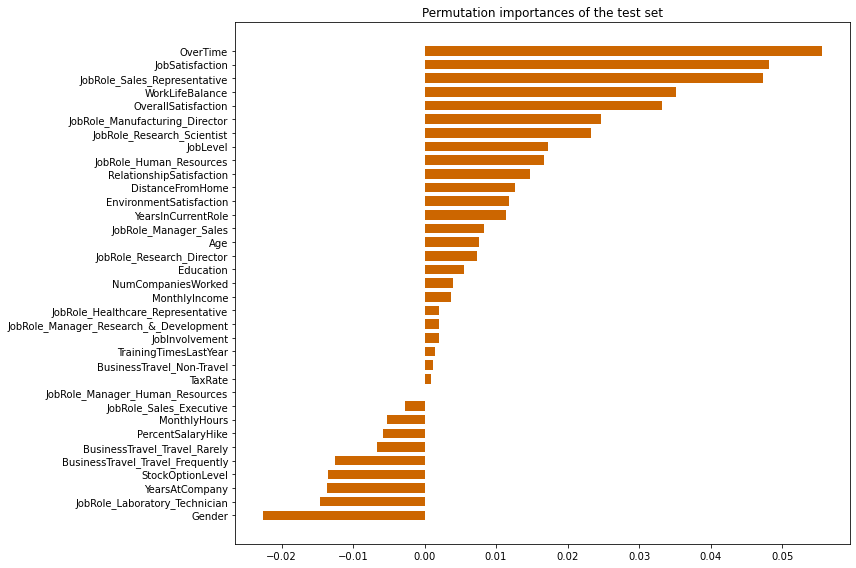



Confusion matrix


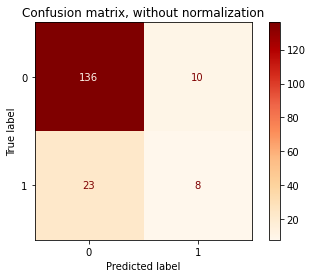

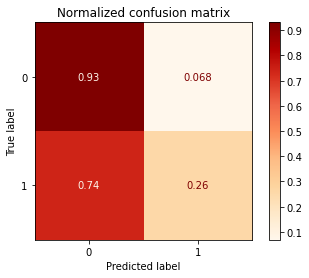


Classification report
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       146
           1       0.44      0.26      0.33        31

    accuracy                           0.81       177
   macro avg       0.65      0.59      0.61       177
weighted avg       0.78      0.81      0.79       177


Metrics

Accuracy 0.8135593220338984
F1-score [0.89180328 0.32653061]
Precision [0.85534591 0.44444444]
Recall [0.93150685 0.25806452]
Roc_auc 0.5947856827220503


Roc curve



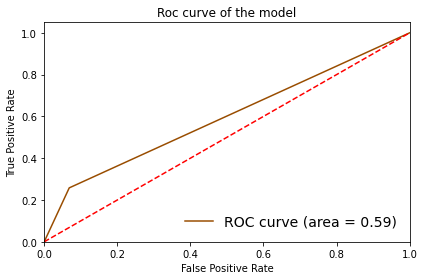


-------------------------------------------------------------------------------------------------------------



In [14]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
min_max_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, min_max_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = min_max_dict

<h4>MaxAbsScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5963905609747253
Best parameters: {'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=9, weights='distance')

Best k ('n_neighbors'): 9

Plots of the metrics used by the grid search


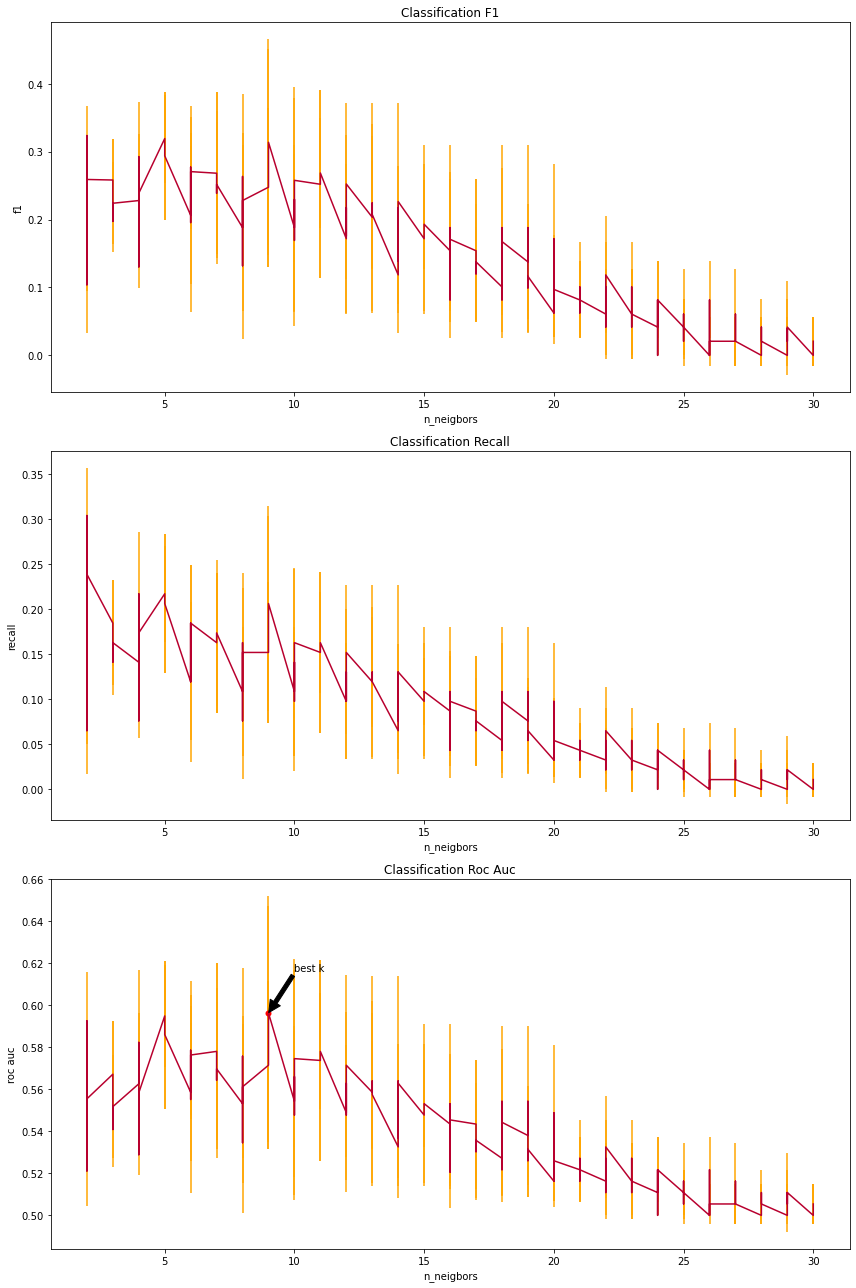



Permutation importances of the training set

OverTime                                           0.040227
Gender                                             0.017065
TaxRate                                            0.015158
JobRole_Laboratory_Technician                      0.014862
BusinessTravel_Travel_Rarely                       0.014046
RelationshipSatisfaction                           0.013956
EnvironmentSatisfaction                            0.012041
JobRole_Research_Scientist                         0.010409
JobSatisfaction                                    0.009877
DistanceFromHome                                   0.009447
StockOptionLevel                                   0.008954
JobRole_Sales_Executive                            0.008750
NumCompaniesWorked                                 0.008546
BusinessTravel_Travel_Frequently                   0.006596
MonthlyHours                                       0.005375
YearsAtCompany                                     0.

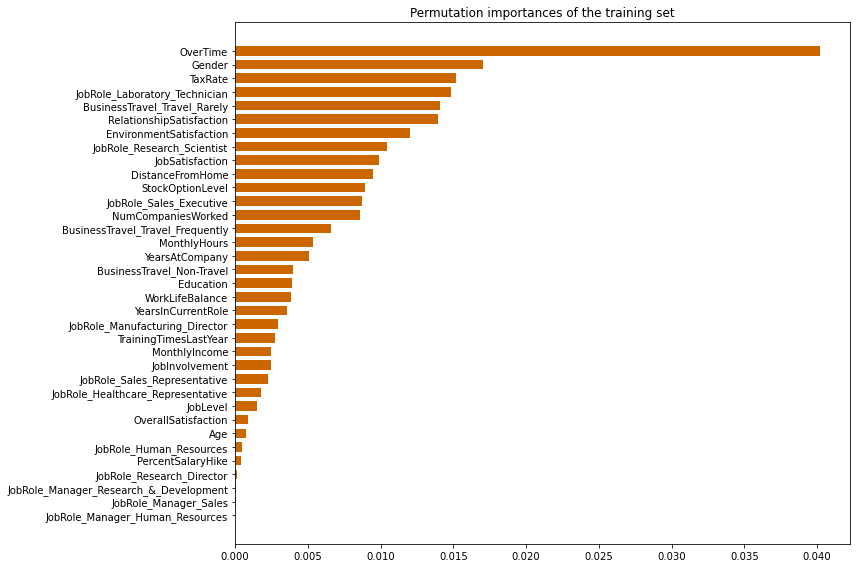



Predictions

Permutation importances of the test set

OverTime                                           0.054901
BusinessTravel_Travel_Frequently                   0.020987
JobRole_Manufacturing_Director                     0.016757
MonthlyIncome                                      0.015081
JobRole_Research_Director                          0.011075
JobRole_Laboratory_Technician                      0.010460
YearsInCurrentRole                                 0.009640
JobRole_Sales_Representative                       0.009601
StockOptionLevel                                   0.008636
Age                                                0.008451
Education                                          0.008426
EnvironmentSatisfaction                            0.007662
JobLevel                                           0.007108
PercentSalaryHike                                  0.006661
WorkLifeBalance                                    0.006560
OverallSatisfaction                         

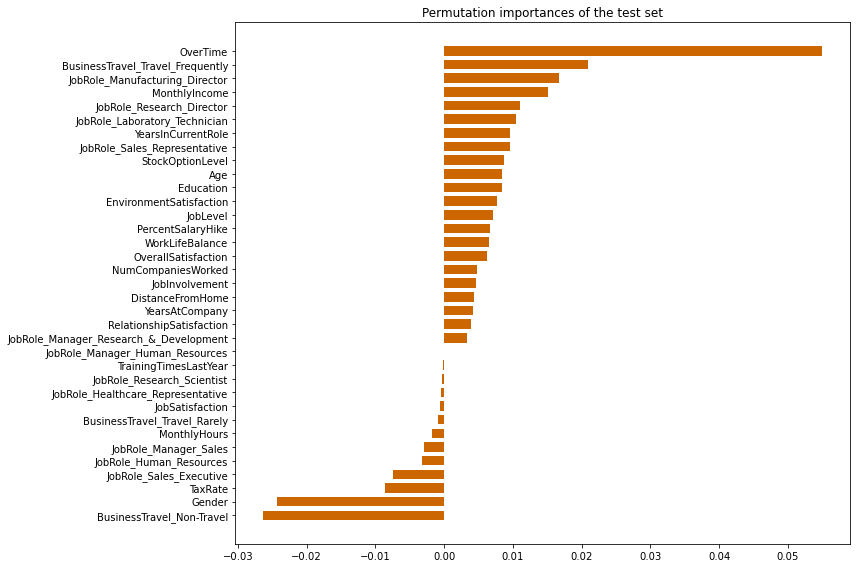



Confusion matrix


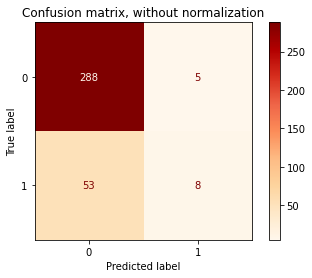

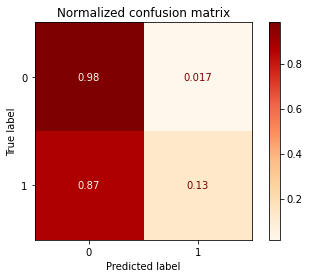


Classification report
              precision    recall  f1-score   support

           0       0.84      0.98      0.91       293
           1       0.62      0.13      0.22        61

    accuracy                           0.84       354
   macro avg       0.73      0.56      0.56       354
weighted avg       0.81      0.84      0.79       354


Metrics

Accuracy 0.8361581920903954
F1-score [0.90851735 0.21621622]
Precision [0.84457478 0.61538462]
Recall [0.98293515 0.13114754]
Roc_auc 0.5570413472836121


Roc curve



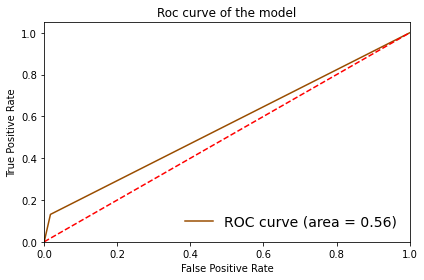


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5994503278736792
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


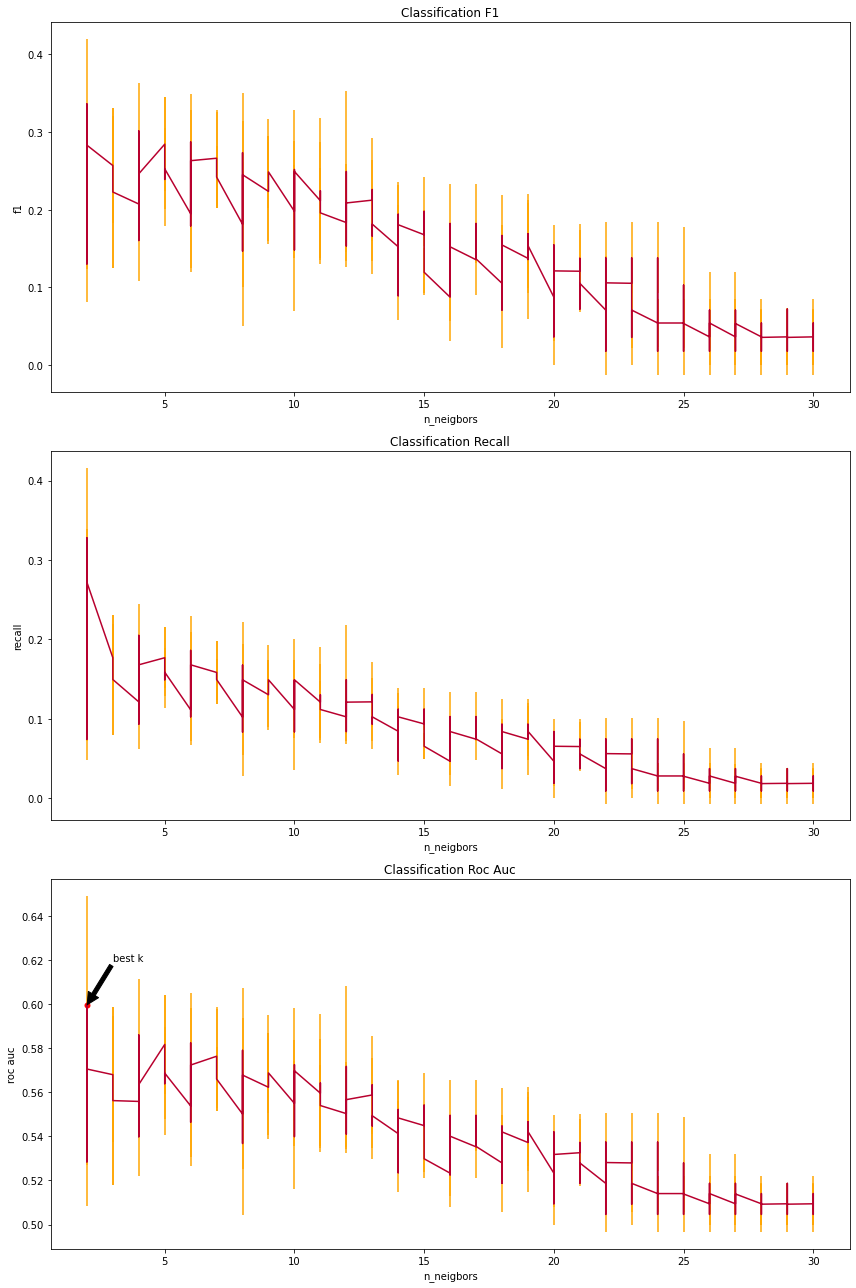



Permutation importances of the training set

Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Human_Resources                    0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manager_Sales                              0.

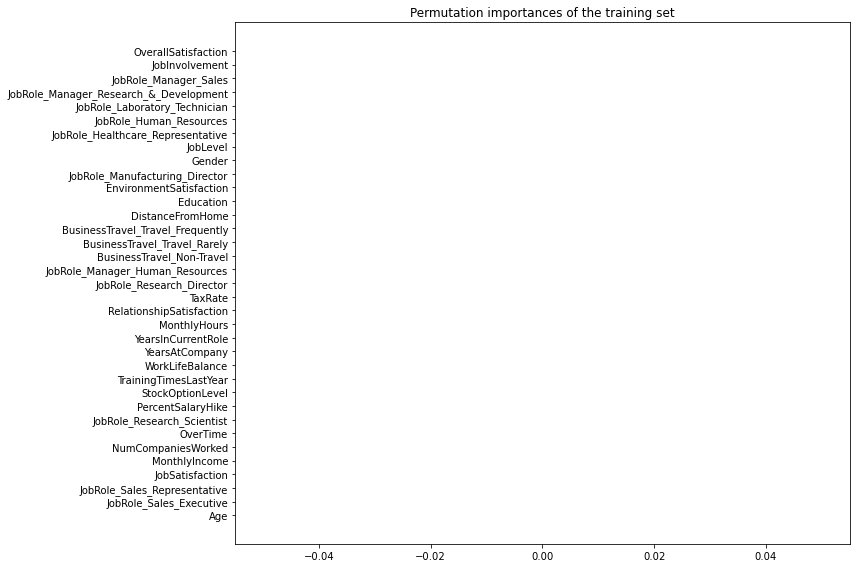



Predictions

Permutation importances of the test set

OverTime                                           0.041974
JobSatisfaction                                    0.022255
JobRole_Research_Scientist                         0.022171
JobLevel                                           0.018597
JobRole_Sales_Representative                       0.012046
JobRole_Sales_Executive                            0.007678
YearsInCurrentRole                                 0.006626
WorkLifeBalance                                    0.006517
JobRole_Manufacturing_Director                     0.005172
JobRole_Manager_Sales                              0.003574
JobRole_Research_Director                          0.001355
EnvironmentSatisfaction                            0.001191
JobRole_Manager_Research_&_Development             0.000834
BusinessTravel_Travel_Frequently                   0.000367
JobRole_Manager_Human_Resources                    0.000010
StockOptionLevel                            

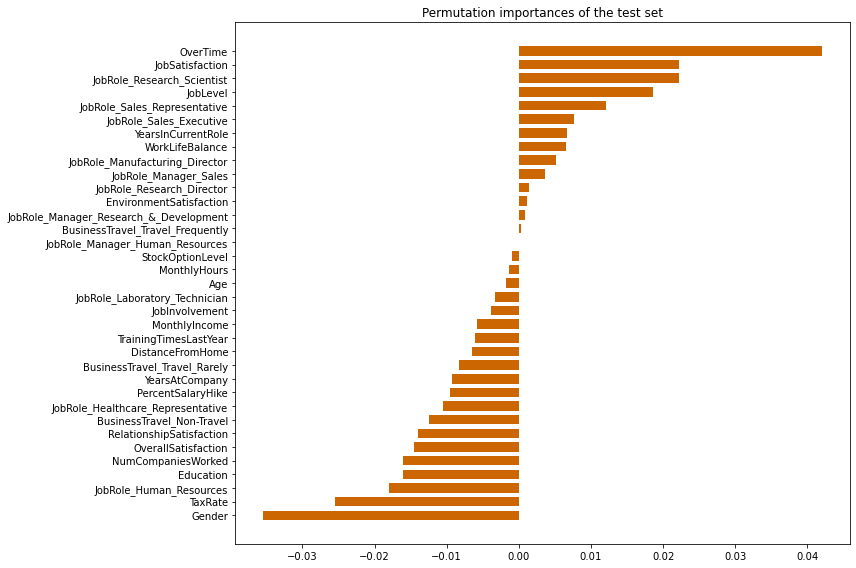



Confusion matrix


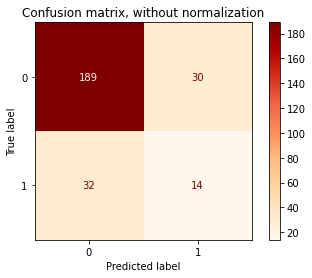

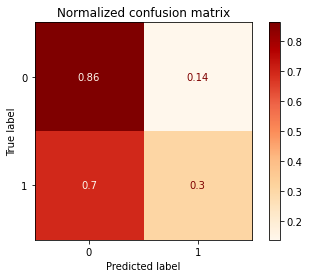


Classification report
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       219
           1       0.32      0.30      0.31        46

    accuracy                           0.77       265
   macro avg       0.59      0.58      0.59       265
weighted avg       0.76      0.77      0.76       265


Metrics

Accuracy 0.7660377358490567
F1-score [0.85909091 0.31111111]
Precision [0.85520362 0.31818182]
Recall [0.8630137  0.30434783]
Roc_auc 0.5836807623585468


Roc curve



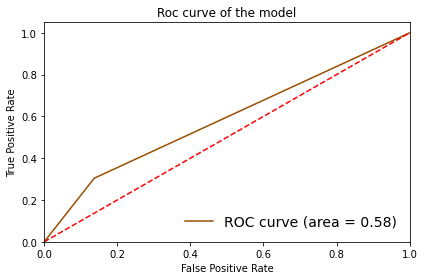


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.595908823096185
Best parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(p=1)

Best k ('n_neighbors'): 5

Plots of the metrics used by the grid search


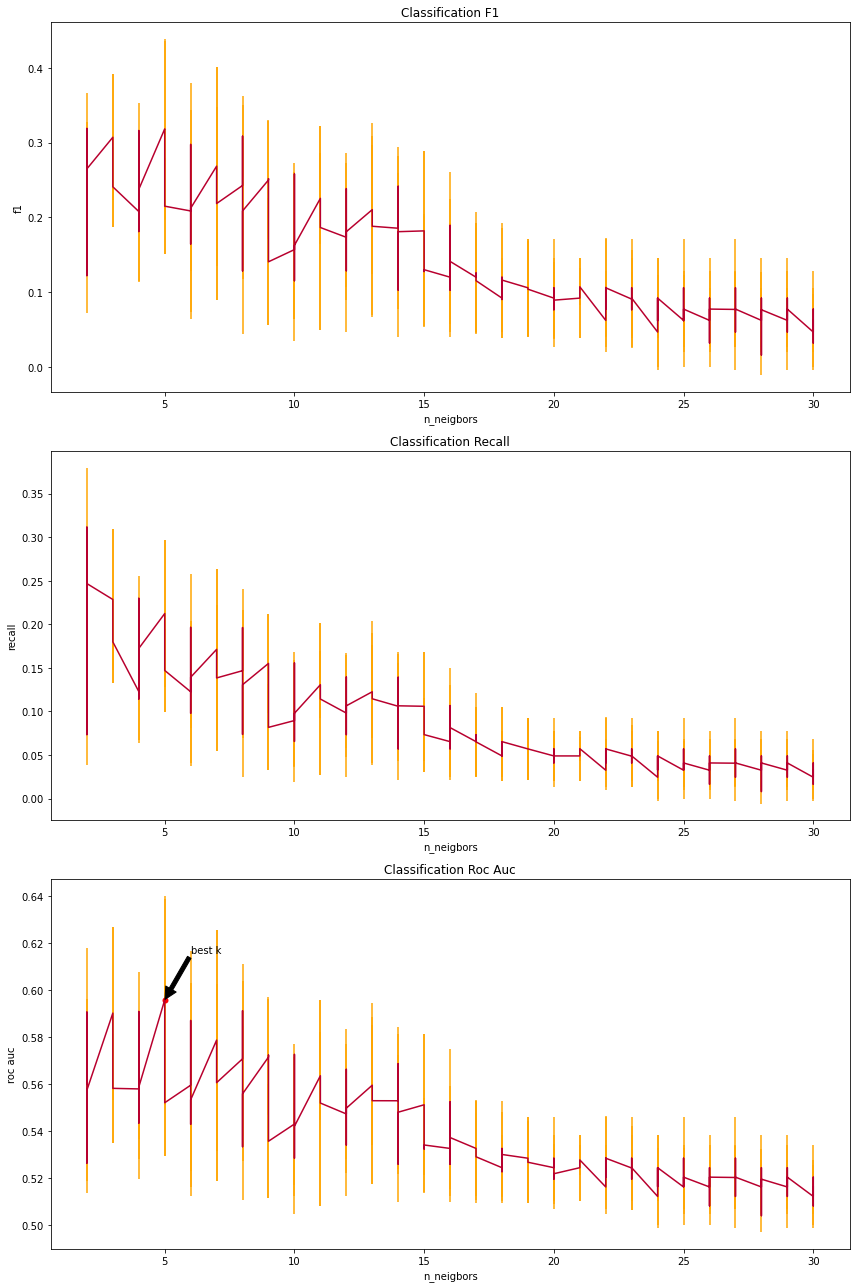



Permutation importances of the training set

OverTime                                           0.025627
StockOptionLevel                                   0.011088
JobRole_Sales_Representative                       0.009856
EnvironmentSatisfaction                            0.007538
TrainingTimesLastYear                              0.005857
RelationshipSatisfaction                           0.004725
JobInvolvement                                     0.004704
JobRole_Laboratory_Technician                      0.004078
JobSatisfaction                                    0.002830
MonthlyIncome                                      0.002765
MonthlyHours                                       0.002176
JobRole_Research_Director                          0.002103
Education                                          0.001472
YearsInCurrentRole                                 0.001368
DistanceFromHome                                   0.001270
JobRole_Manufacturing_Director                     0.

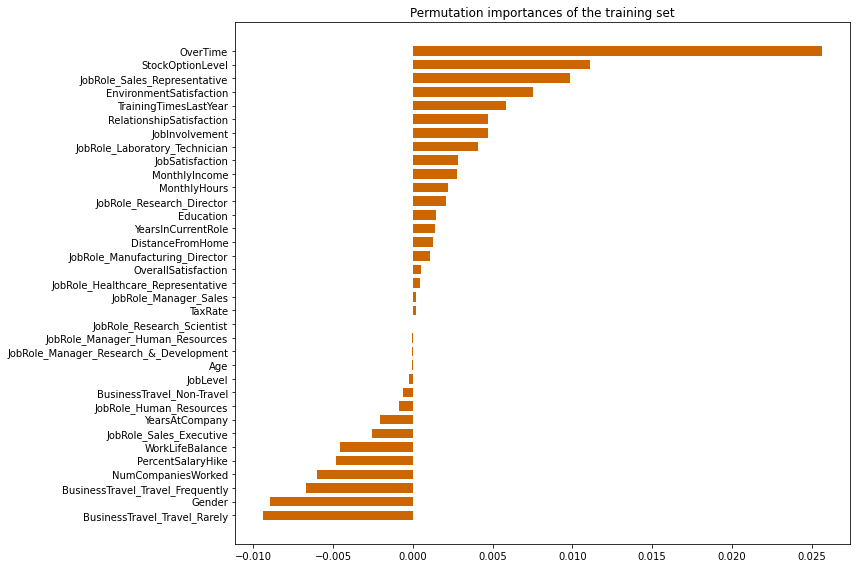



Predictions

Permutation importances of the test set

OverTime                                           0.049945
YearsInCurrentRole                                 0.034412
JobSatisfaction                                    0.029894
JobRole_Sales_Representative                       0.029054
OverallSatisfaction                                0.024635
NumCompaniesWorked                                 0.022978
WorkLifeBalance                                    0.021454
JobRole_Manufacturing_Director                     0.021365
Age                                                0.016869
JobInvolvement                                     0.016715
RelationshipSatisfaction                           0.016019
JobLevel                                           0.015776
DistanceFromHome                                   0.014814
JobRole_Human_Resources                            0.014240
JobRole_Research_Director                          0.011202
MonthlyHours                                

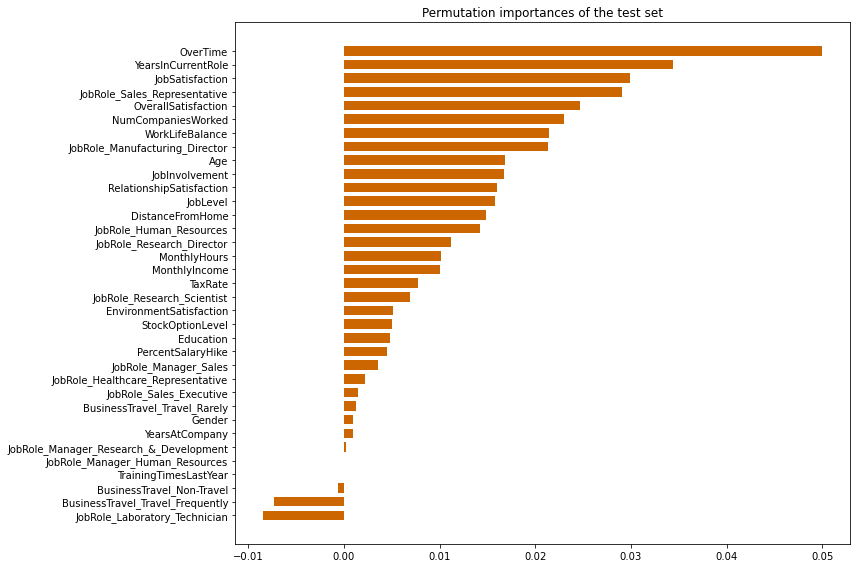



Confusion matrix


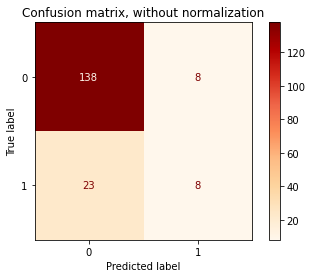

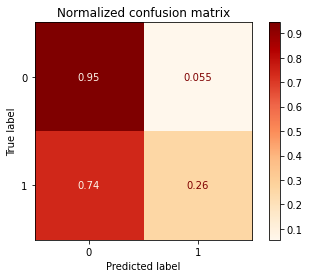


Classification report
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       146
           1       0.50      0.26      0.34        31

    accuracy                           0.82       177
   macro avg       0.68      0.60      0.62       177
weighted avg       0.79      0.82      0.80       177


Metrics

Accuracy 0.8248587570621468
F1-score [0.8990228  0.34042553]
Precision [0.85714286 0.5       ]
Recall [0.94520548 0.25806452]
Roc_auc 0.6016349977905435


Roc curve



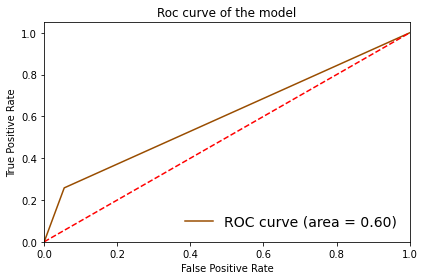


-------------------------------------------------------------------------------------------------------------



In [15]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
max_abs_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MaxAbsScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, max_abs_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = max_abs_dict

<h4>RobustScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5929501940022484
Best parameters: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

Best k ('n_neighbors'): 6

Plots of the metrics used by the grid search


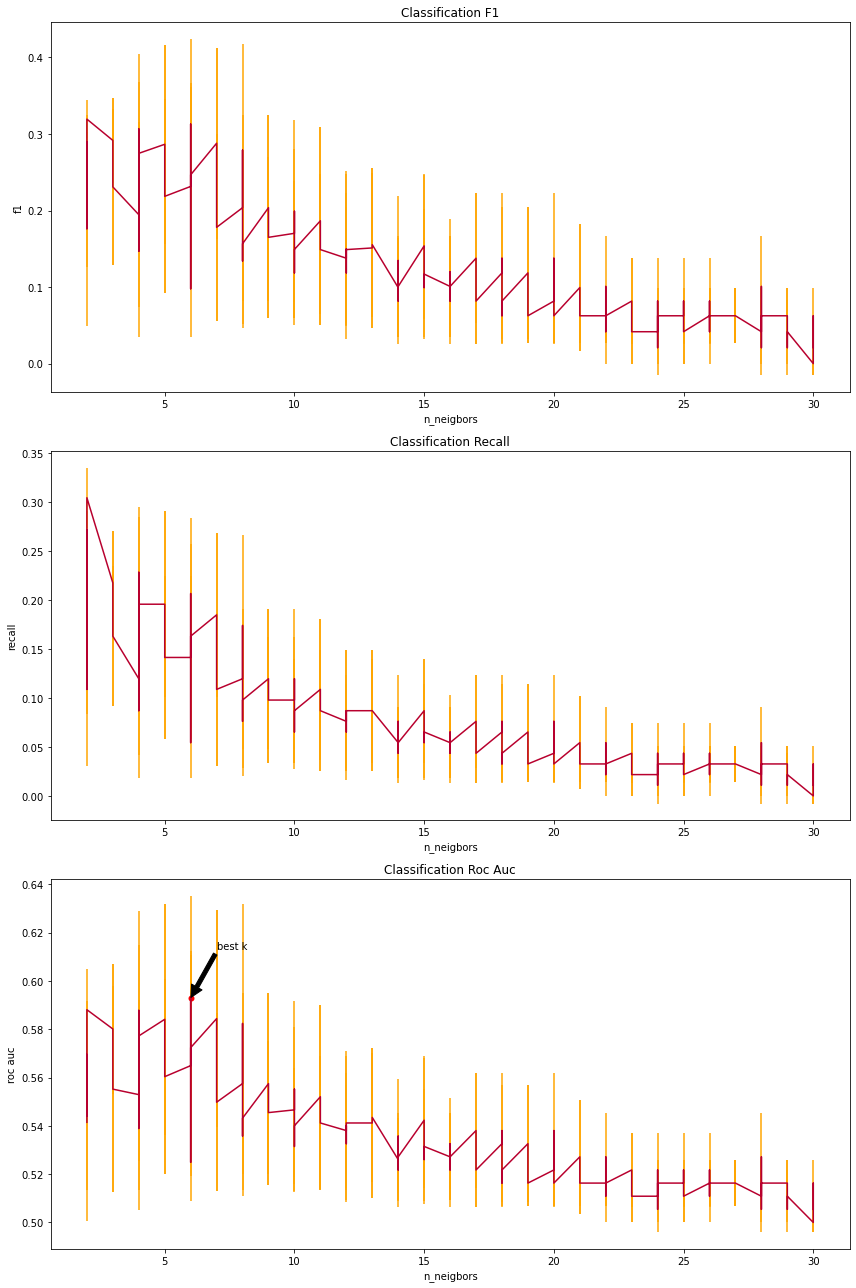



Permutation importances of the training set

StockOptionLevel                                   0.000137
TrainingTimesLastYear                              0.000060
MonthlyIncome                                      0.000060
Age                                                0.000012
JobLevel                                           0.000012
WorkLifeBalance                                    0.000005
JobInvolvement                                     0.000002
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.

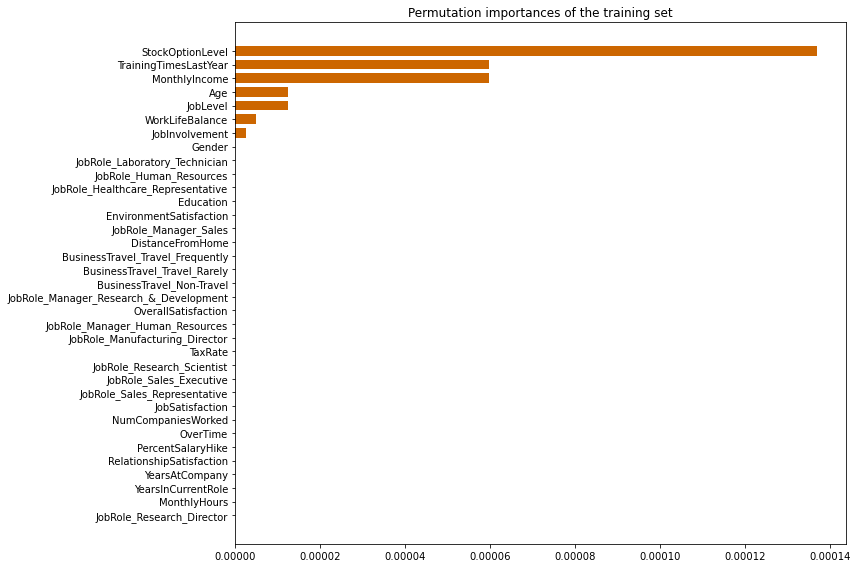



Predictions

Permutation importances of the test set

OverTime                                           0.057956
JobLevel                                           0.055147
StockOptionLevel                                   0.052350
MonthlyIncome                                      0.044052
YearsInCurrentRole                                 0.034348
JobRole_Laboratory_Technician                      0.020380
BusinessTravel_Travel_Frequently                   0.019904
Age                                                0.018752
BusinessTravel_Travel_Rarely                       0.018055
NumCompaniesWorked                                 0.016933
JobSatisfaction                                    0.015487
RelationshipSatisfaction                           0.013775
JobRole_Sales_Executive                            0.013588
OverallSatisfaction                                0.013257
WorkLifeBalance                                    0.012393
JobInvolvement                              

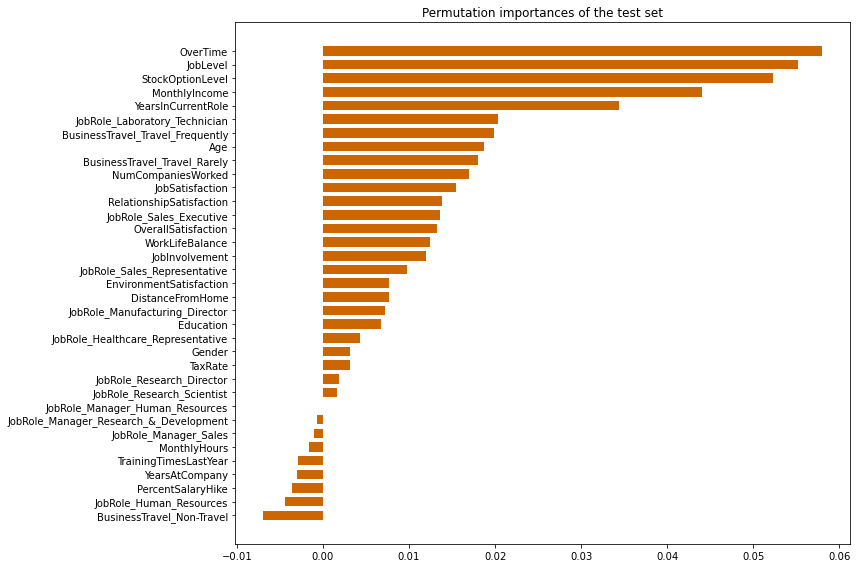



Confusion matrix


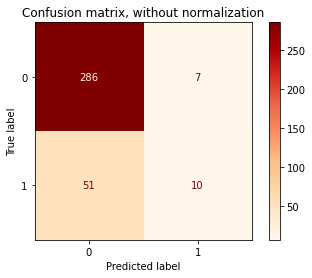

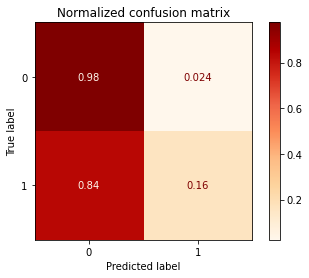


Classification report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       293
           1       0.59      0.16      0.26        61

    accuracy                           0.84       354
   macro avg       0.72      0.57      0.58       354
weighted avg       0.80      0.84      0.80       354


Metrics

Accuracy 0.8361581920903954
F1-score [0.90793651 0.25641026]
Precision [0.84866469 0.58823529]
Recall [0.97610922 0.16393443]
Roc_auc 0.5700218206232864


Roc curve



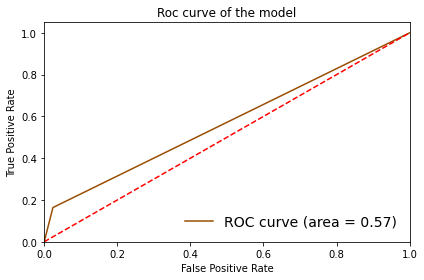


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5992877974838482
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


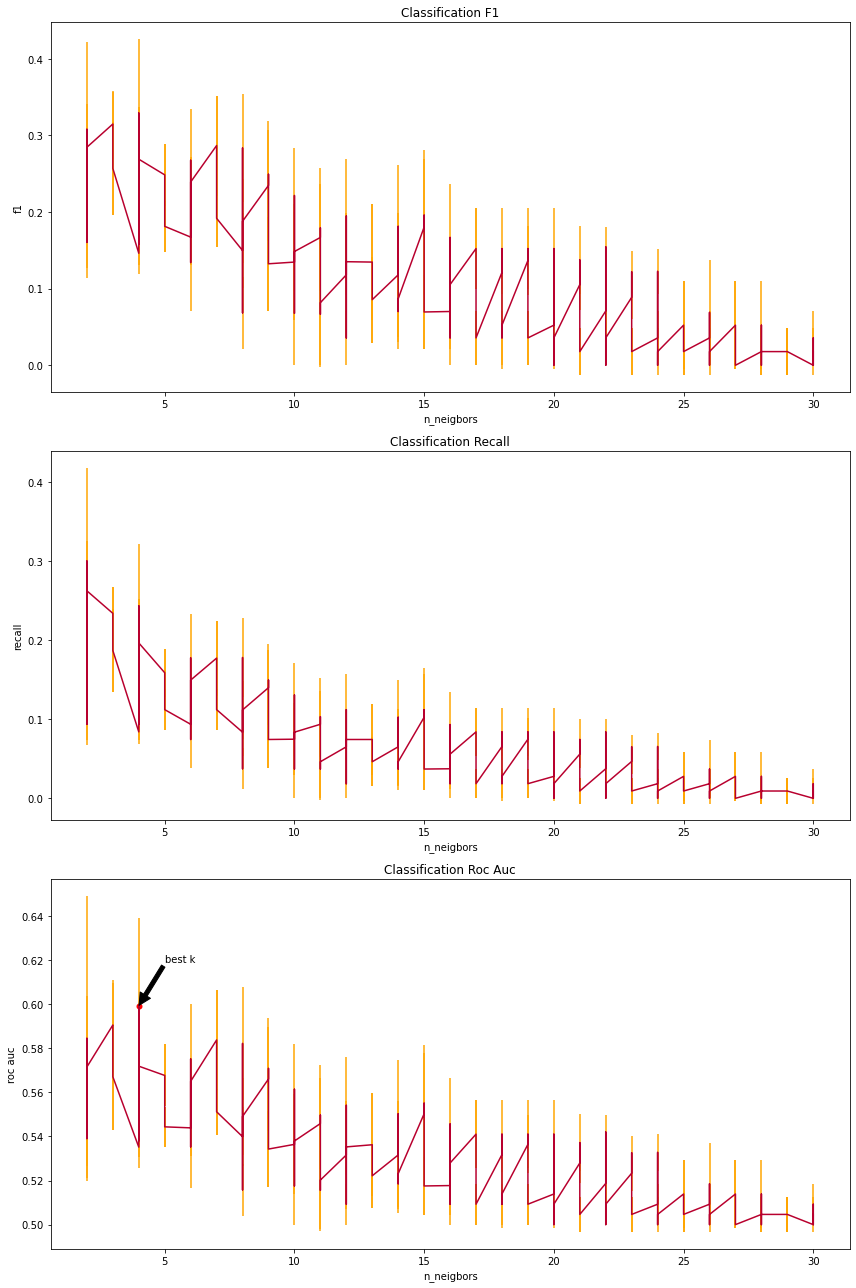



Permutation importances of the training set

StockOptionLevel                                   0.000015
MonthlyIncome                                      0.000002
TrainingTimesLastYear                              0.000002
Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.000000
JobRole_Laboratory_Technician                      0.

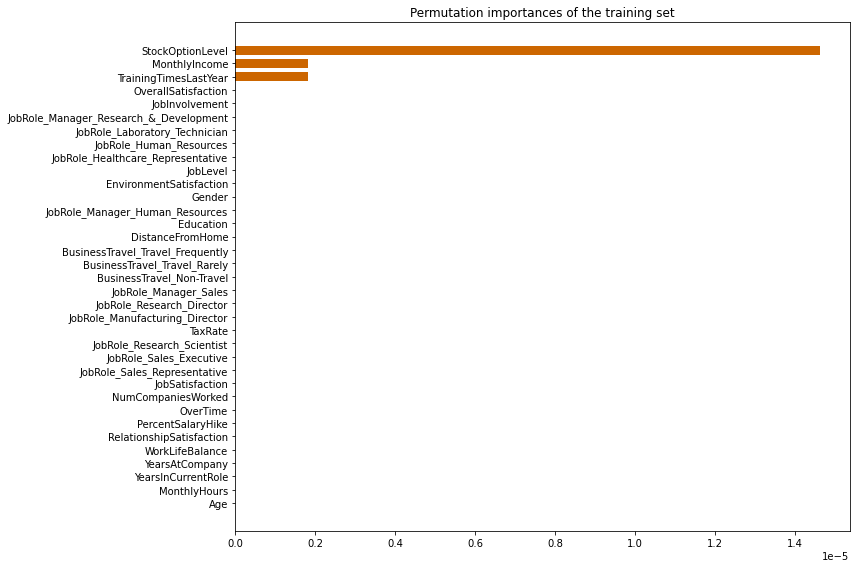



Predictions

Permutation importances of the test set

OverTime                                           0.060651
MonthlyIncome                                      0.035433
JobSatisfaction                                    0.027104
Education                                          0.025710
JobLevel                                           0.023551
StockOptionLevel                                   0.020871
JobInvolvement                                     0.018329
JobRole_Research_Scientist                         0.016245
YearsInCurrentRole                                 0.013957
JobRole_Manufacturing_Director                     0.010661
TaxRate                                            0.009515
JobRole_Sales_Executive                            0.007529
DistanceFromHome                                   0.007430
JobRole_Healthcare_Representative                  0.006269
OverallSatisfaction                                0.004988
JobRole_Human_Resources                     

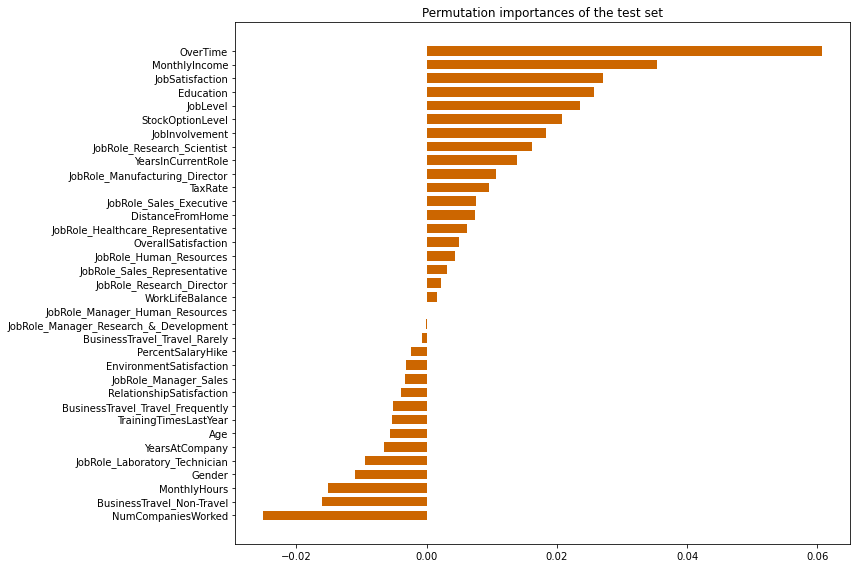



Confusion matrix


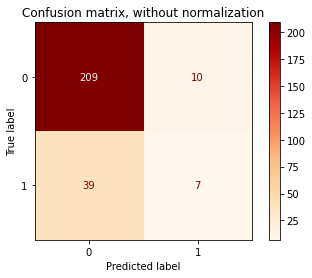

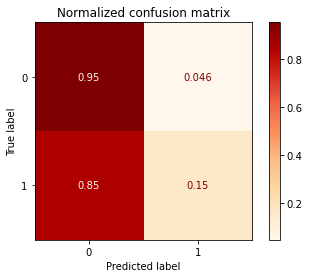


Classification report
              precision    recall  f1-score   support

           0       0.84      0.95      0.90       219
           1       0.41      0.15      0.22        46

    accuracy                           0.82       265
   macro avg       0.63      0.55      0.56       265
weighted avg       0.77      0.82      0.78       265


Metrics

Accuracy 0.8150943396226416
F1-score [0.89507495 0.22222222]
Precision [0.84274194 0.41176471]
Recall [0.9543379  0.15217391]
Roc_auc 0.5532559062934286


Roc curve



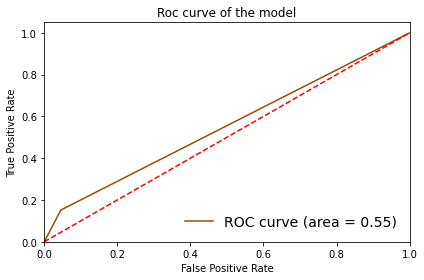


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.637621520106054
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


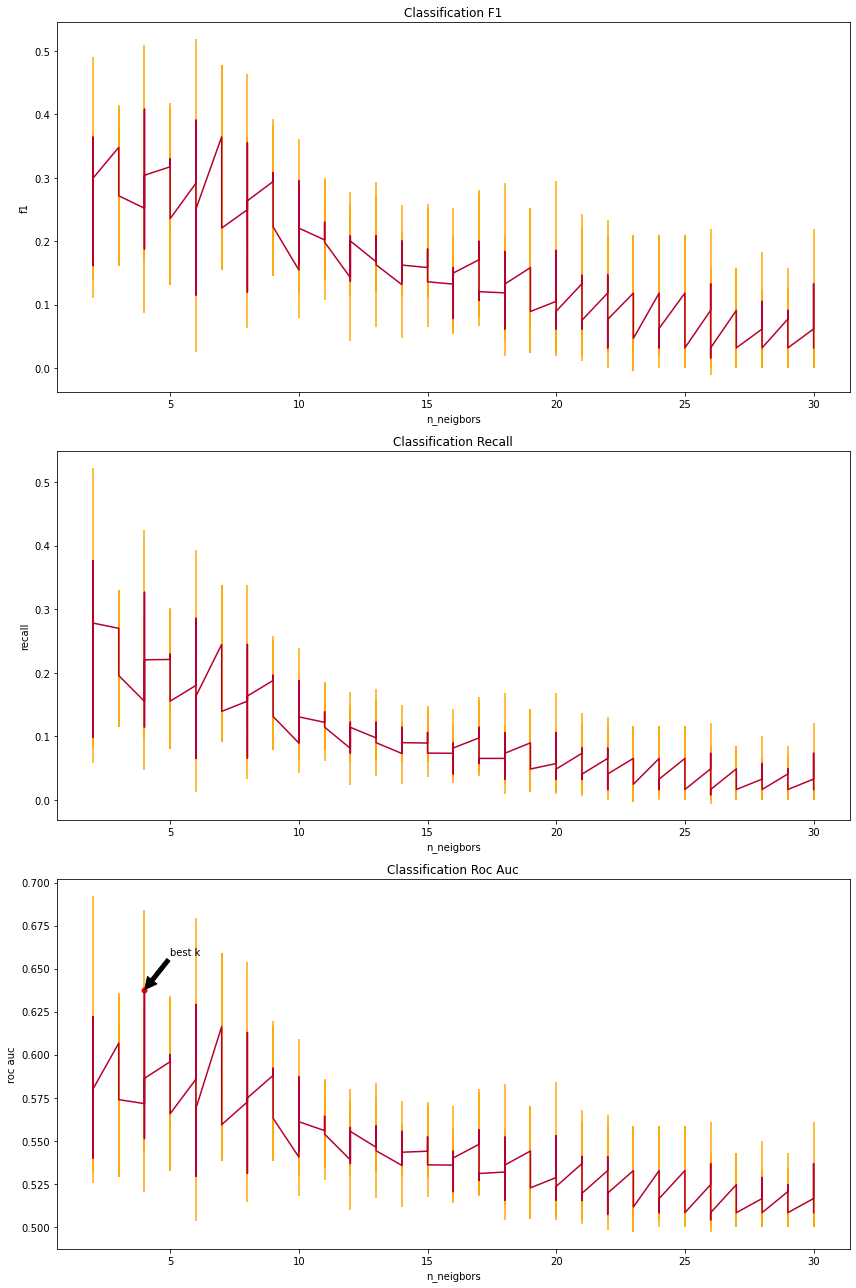



Permutation importances of the training set

TrainingTimesLastYear                              0.000094
StockOptionLevel                                   0.000004
WorkLifeBalance                                    0.000001
Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.000000
JobRole_Laboratory_Technician                      0.

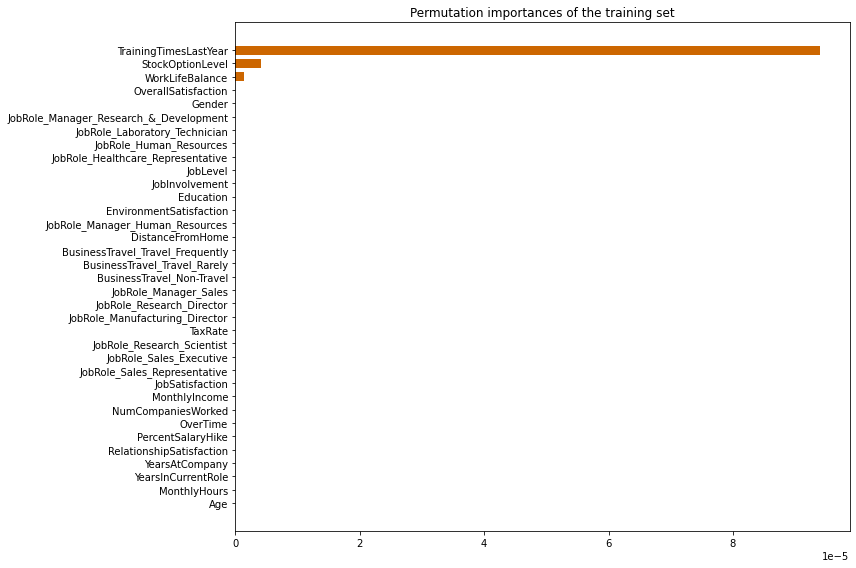



Predictions

Permutation importances of the test set

OverTime                                           0.060639
JobRole_Research_Scientist                         0.030579
StockOptionLevel                                   0.026038
JobSatisfaction                                    0.025276
TrainingTimesLastYear                              0.020040
JobInvolvement                                     0.018471
JobLevel                                           0.013500
WorkLifeBalance                                    0.011169
Education                                          0.010826
YearsInCurrentRole                                 0.009534
JobRole_Manufacturing_Director                     0.009158
JobRole_Sales_Executive                            0.008484
JobRole_Human_Resources                            0.008230
JobRole_Healthcare_Representative                  0.007446
BusinessTravel_Travel_Frequently                   0.006352
JobRole_Research_Director                   

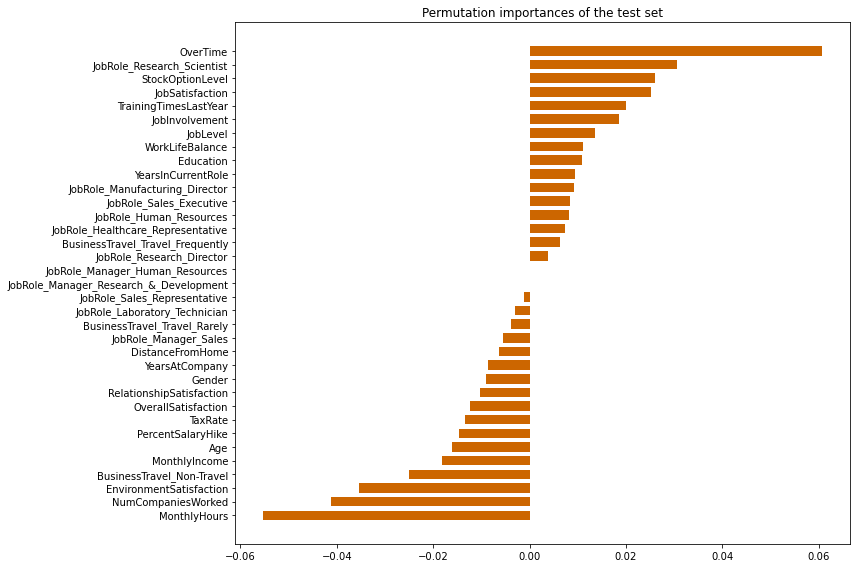



Confusion matrix


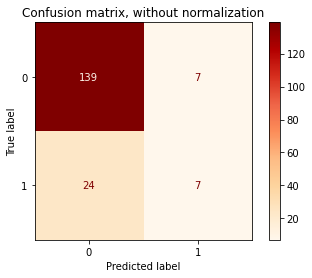

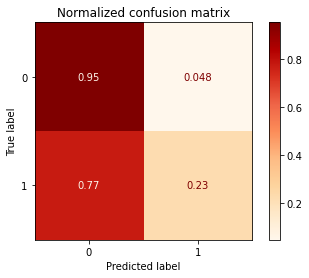


Classification report
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       146
           1       0.50      0.23      0.31        31

    accuracy                           0.82       177
   macro avg       0.68      0.59      0.61       177
weighted avg       0.79      0.82      0.80       177


Metrics

Accuracy 0.8248587570621468
F1-score [0.89967638 0.31111111]
Precision [0.85276074 0.5       ]
Recall [0.95205479 0.22580645]
Roc_auc 0.5889306230667256


Roc curve



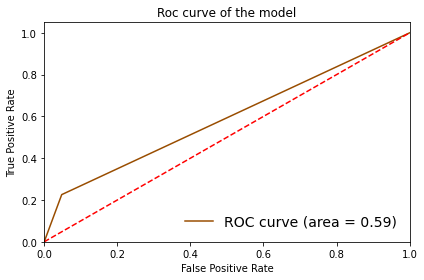


-------------------------------------------------------------------------------------------------------------



In [16]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
robust_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = RobustScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, robust_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = robust_dict

<h4>StandardScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6115816622547775
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


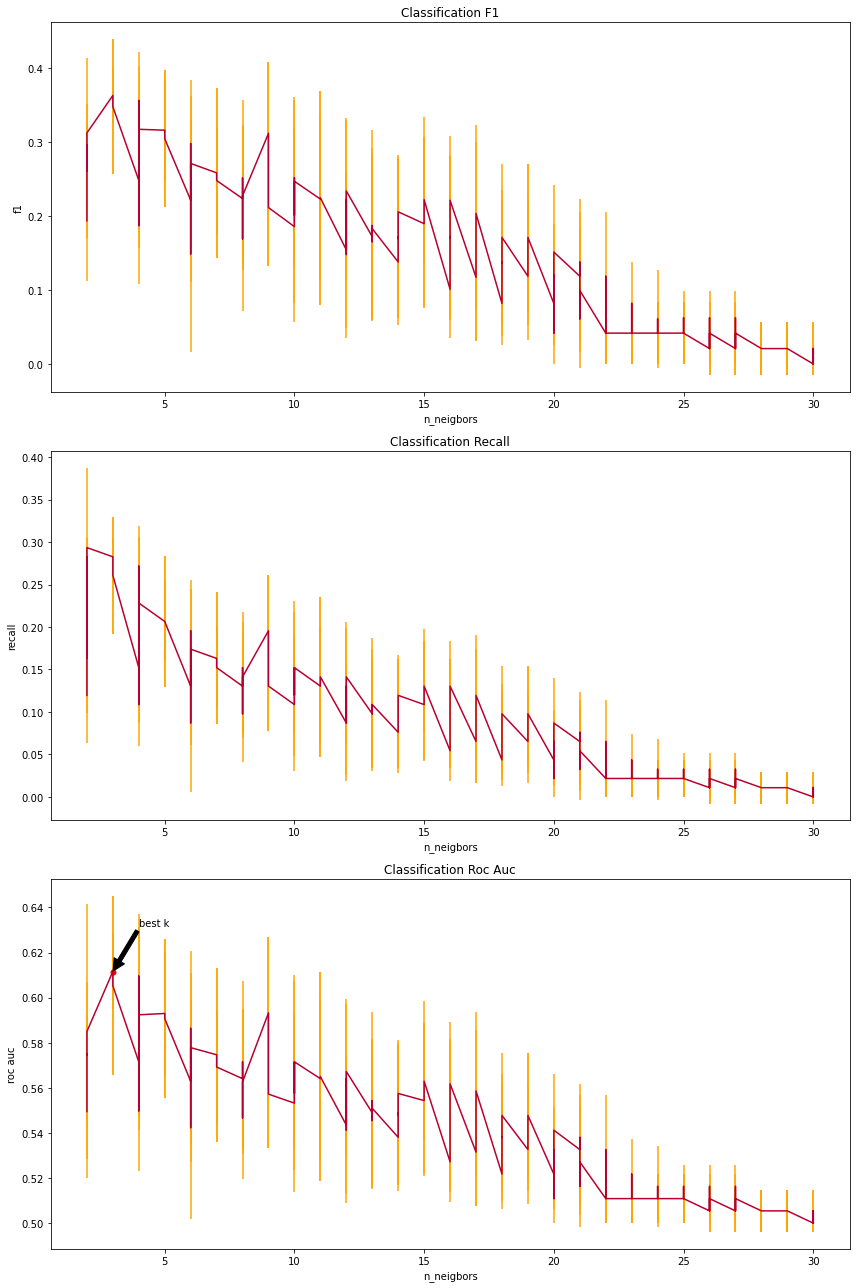



Permutation importances of the training set

OverTime                                           0.010319
JobSatisfaction                                    0.005637
JobRole_Manufacturing_Director                     0.005458
JobRole_Sales_Representative                       0.003960
StockOptionLevel                                   0.003396
JobRole_Sales_Executive                            0.003007
JobRole_Laboratory_Technician                      0.002057
WorkLifeBalance                                    0.002037
JobRole_Healthcare_Representative                  0.001771
JobRole_Human_Resources                            0.001684
EnvironmentSatisfaction                            0.001568
JobLevel                                           0.001214
Age                                                0.001129
JobRole_Research_Director                          0.001063
JobInvolvement                                     0.000807
YearsInCurrentRole                                 0.

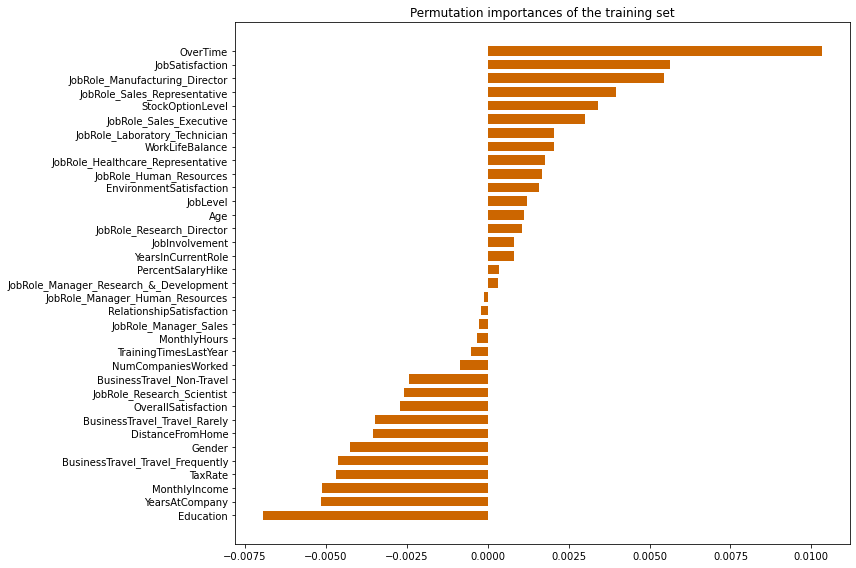



Predictions

Permutation importances of the test set

OverTime                                           0.028300
JobLevel                                           0.022075
JobRole_Manufacturing_Director                     0.012046
JobRole_Sales_Representative                       0.010390
StockOptionLevel                                   0.008625
JobRole_Healthcare_Representative                  0.006325
JobRole_Research_Director                          0.004837
JobRole_Manager_Human_Resources                    0.000643
JobRole_Manager_Research_&_Development             -0.000733
JobRole_Laboratory_Technician                      -0.001136
JobRole_Human_Resources                            -0.003228
JobRole_Manager_Sales                              -0.004124
WorkLifeBalance                                    -0.006818
JobRole_Research_Scientist                         -0.007067
JobInvolvement                                     -0.008314
MonthlyIncome                        

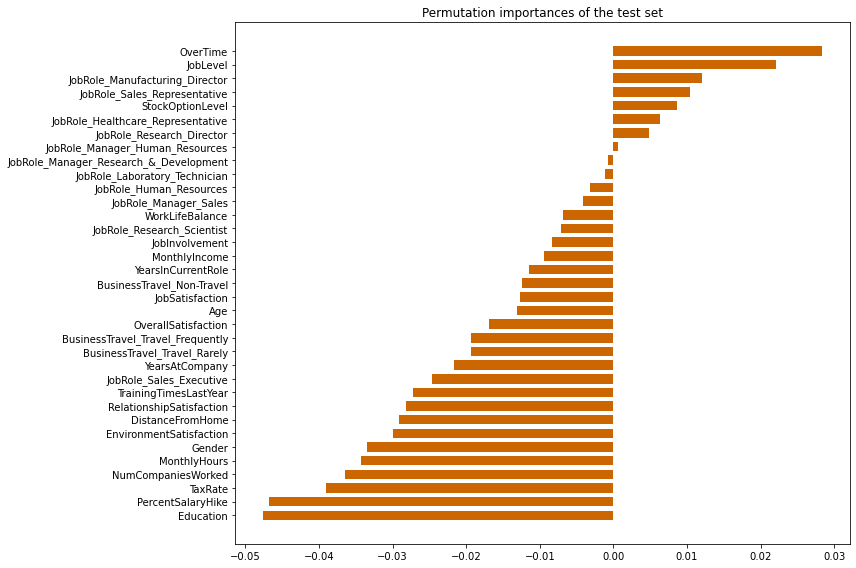



Confusion matrix


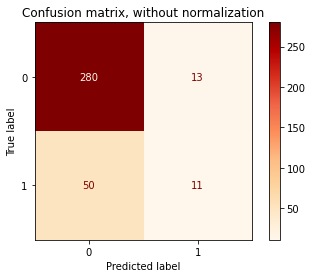

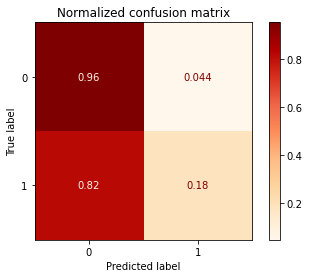


Classification report
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       293
           1       0.46      0.18      0.26        61

    accuracy                           0.82       354
   macro avg       0.65      0.57      0.58       354
weighted avg       0.78      0.82      0.79       354


Metrics

Accuracy 0.8220338983050848
F1-score [0.8988764  0.25882353]
Precision [0.84848485 0.45833333]
Recall [0.9556314  0.18032787]
Roc_auc 0.5679796340849326


Roc curve



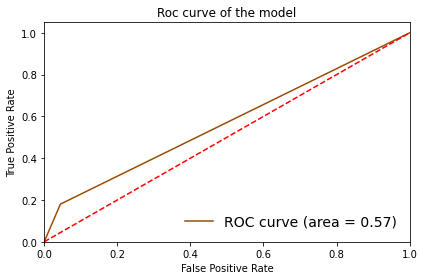


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5908222841585908
Best parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(p=1)

Best k ('n_neighbors'): 5

Plots of the metrics used by the grid search


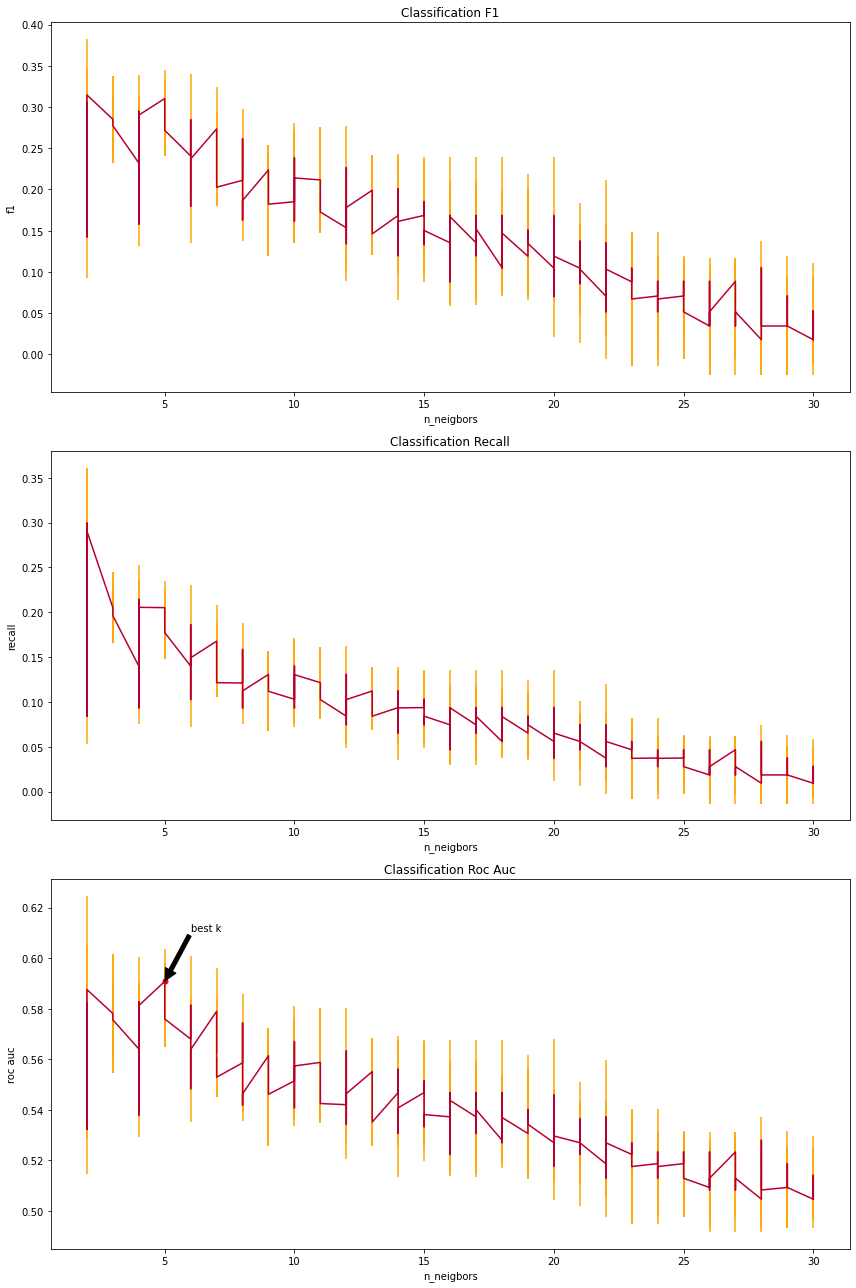



Permutation importances of the training set

OverTime                                           0.012246
StockOptionLevel                                   0.010120
JobRole_Sales_Representative                       0.008269
JobRole_Laboratory_Technician                      0.007897
EnvironmentSatisfaction                            0.005858
JobRole_Manufacturing_Director                     0.005201
TrainingTimesLastYear                              0.003952
JobRole_Manager_Research_&_Development             0.003669
BusinessTravel_Non-Travel                          0.003342
NumCompaniesWorked                                 0.003092
PercentSalaryHike                                  0.002793
JobInvolvement                                     0.002530
YearsInCurrentRole                                 0.002437
JobSatisfaction                                    0.002131
JobRole_Research_Director                          0.002030
MonthlyHours                                       0.

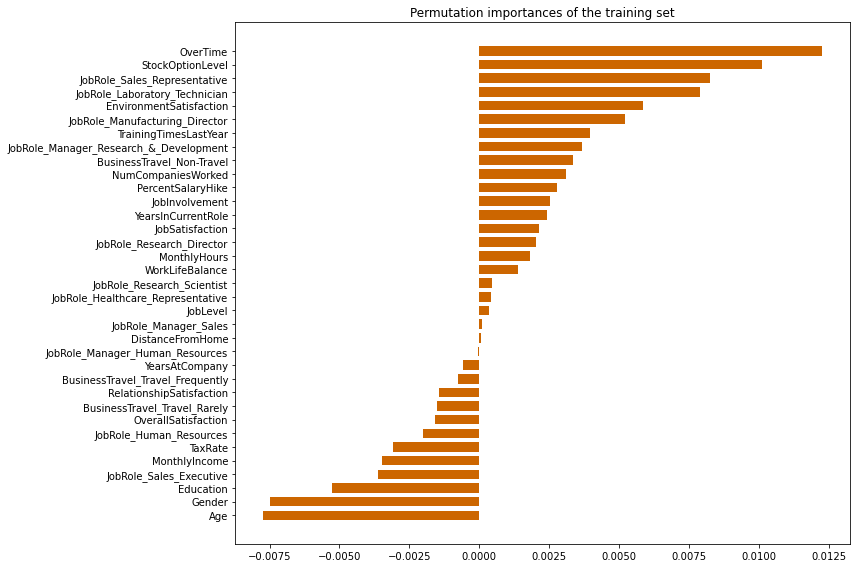



Predictions

Permutation importances of the test set

OverTime                                           0.032400
JobLevel                                           0.030003
StockOptionLevel                                   0.026578
JobRole_Healthcare_Representative                  0.019908
JobRole_Research_Director                          0.011768
JobRole_Human_Resources                            0.006909
BusinessTravel_Travel_Rarely                       0.006075
JobRole_Manufacturing_Director                     0.004695
JobSatisfaction                                    0.003832
JobRole_Sales_Representative                       0.003663
JobRole_Manager_Research_&_Development             0.001871
EnvironmentSatisfaction                            0.001722
JobInvolvement                                     0.000318
JobRole_Manager_Human_Resources                    -0.000134
JobRole_Laboratory_Technician                      -0.001792
OverallSatisfaction                       

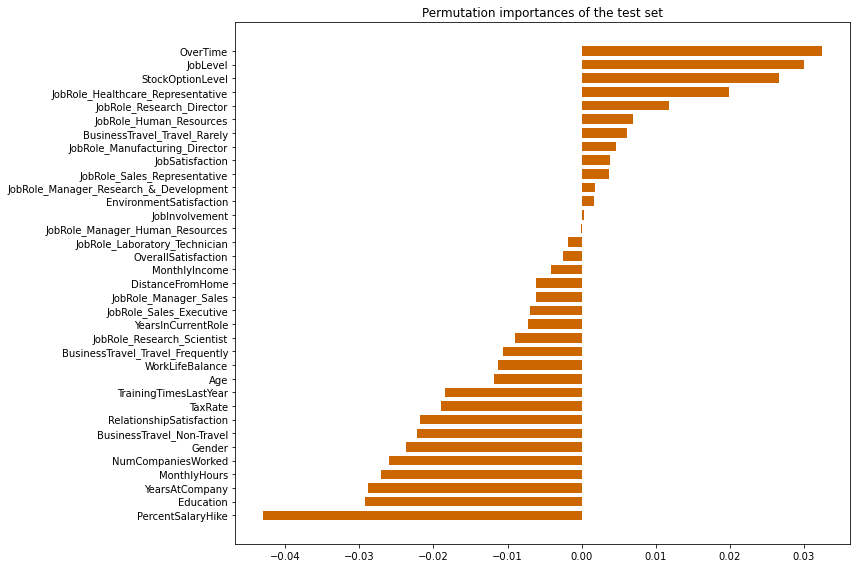



Confusion matrix


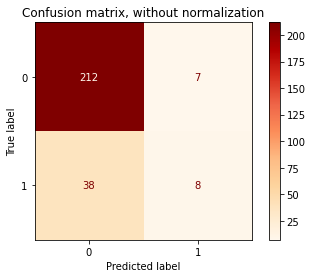

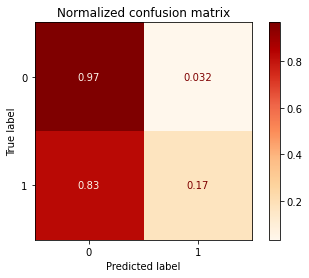


Classification report
              precision    recall  f1-score   support

           0       0.85      0.97      0.90       219
           1       0.53      0.17      0.26        46

    accuracy                           0.83       265
   macro avg       0.69      0.57      0.58       265
weighted avg       0.79      0.83      0.79       265


Metrics

Accuracy 0.8301886792452831
F1-score [0.90405117 0.26229508]
Precision [0.848      0.53333333]
Recall [0.96803653 0.17391304]
Roc_auc 0.570974786579313


Roc curve



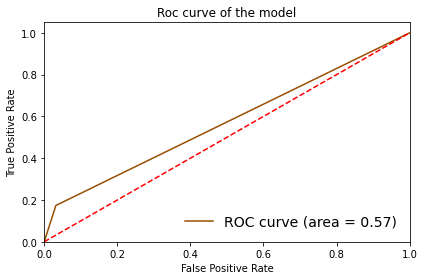


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6291979673000442
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


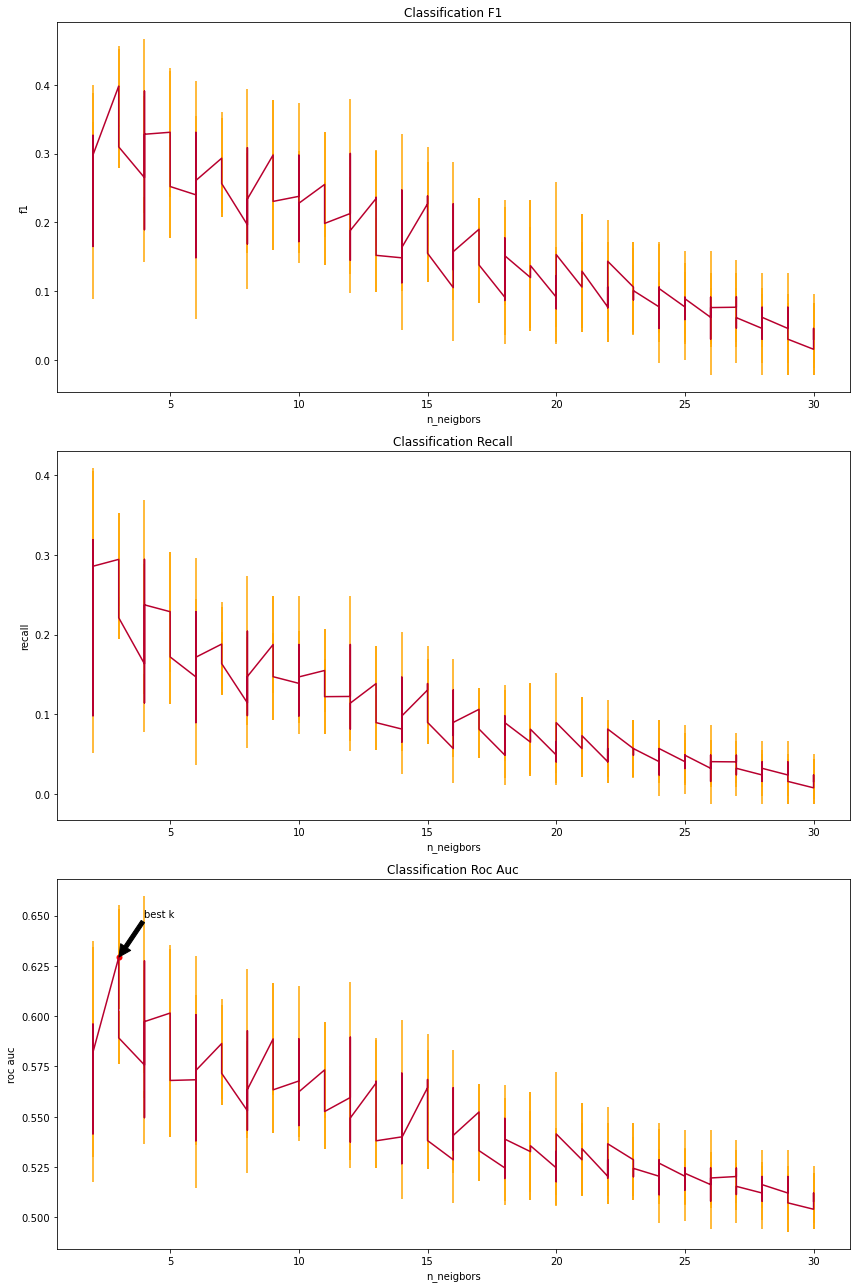



Permutation importances of the training set

Age                                                0.007877
OverTime                                           0.007553
JobRole_Sales_Representative                       0.006266
JobRole_Laboratory_Technician                      0.005460
JobInvolvement                                     0.005175
EnvironmentSatisfaction                            0.004799
YearsAtCompany                                     0.004604
MonthlyHours                                       0.003650
StockOptionLevel                                   0.003106
NumCompaniesWorked                                 0.002806
JobSatisfaction                                    0.002404
YearsInCurrentRole                                 0.002279
JobRole_Manufacturing_Director                     0.002025
JobRole_Sales_Executive                            0.001601
JobRole_Human_Resources                            0.001519
OverallSatisfaction                                0.

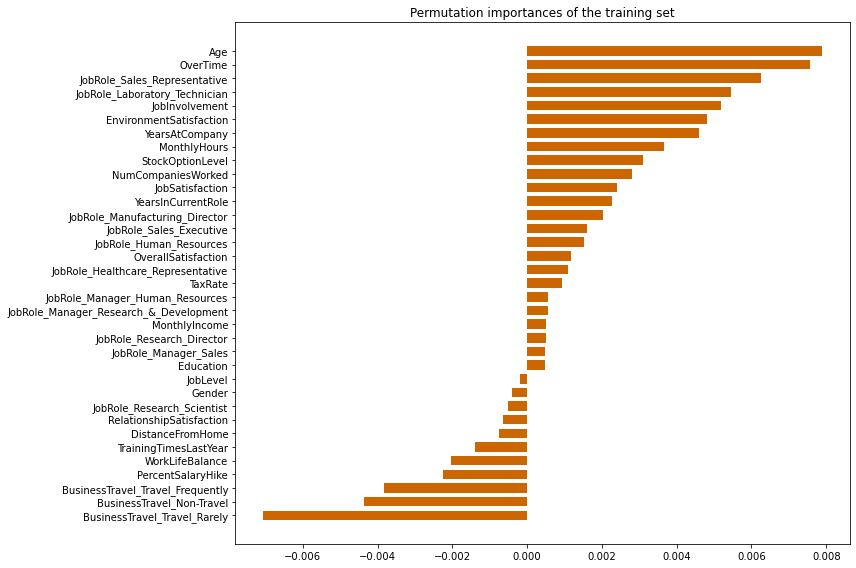



Predictions

Permutation importances of the test set

OverTime                                           0.070449
JobRole_Sales_Representative                       0.045669
WorkLifeBalance                                    0.030667
YearsInCurrentRole                                 0.029596
JobRole_Research_Scientist                         0.029507
JobSatisfaction                                    0.028502
JobLevel                                           0.025453
JobRole_Manufacturing_Director                     0.012671
OverallSatisfaction                                0.011279
JobRole_Research_Director                          0.007733
StockOptionLevel                                   0.006894
BusinessTravel_Travel_Rarely                       0.005855
JobRole_Laboratory_Technician                      0.003259
JobInvolvement                                     0.001049
JobRole_Manager_Human_Resources                    0.000000
JobRole_Healthcare_Representative           

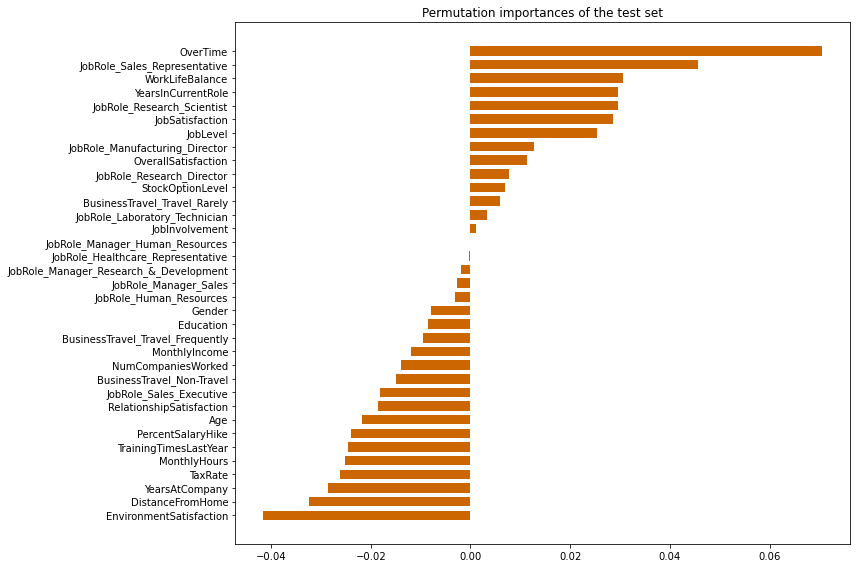



Confusion matrix


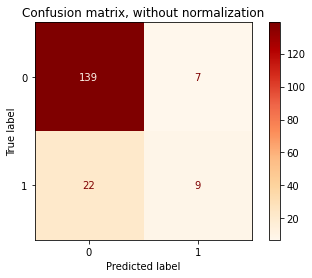

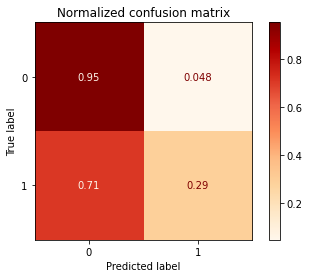


Classification report
              precision    recall  f1-score   support

           0       0.86      0.95      0.91       146
           1       0.56      0.29      0.38        31

    accuracy                           0.84       177
   macro avg       0.71      0.62      0.64       177
weighted avg       0.81      0.84      0.81       177


Metrics

Accuracy 0.8361581920903954
F1-score [0.90553746 0.38297872]
Precision [0.86335404 0.5625    ]
Recall [0.95205479 0.29032258]
Roc_auc 0.6211886875828546


Roc curve



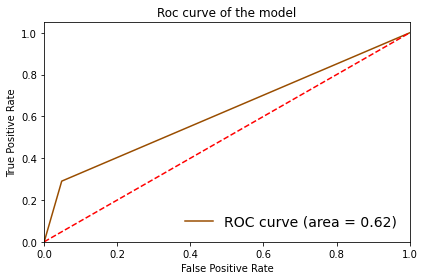


-------------------------------------------------------------------------------------------------------------



In [17]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
standard_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = StandardScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, standard_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = standard_dict

In [18]:
scaler_dict

{'MinMaxScaler': {'60-40': {'fpr': [0.0, 0.017064846416382253, 1.0],
   'tpr': [0.0, 0.16393442622950818, 1.0],
   'roc': 0.5734347899065629},
  '70-30': {'fpr': [0.0, 0.1187214611872146, 1.0],
   'tpr': [0.0, 0.2826086956521739, 1.0],
   'roc': 0.5819436172324797},
  '80-20': {'fpr': [0.0, 0.0684931506849315, 1.0],
   'tpr': [0.0, 0.25806451612903225, 1.0],
   'roc': 0.5947856827220503}},
 'MaxAbsScaler': {'60-40': {'fpr': [0.0, 0.017064846416382253, 1.0],
   'tpr': [0.0, 0.13114754098360656, 1.0],
   'roc': 0.5570413472836121},
  '70-30': {'fpr': [0.0, 0.136986301369863, 1.0],
   'tpr': [0.0, 0.30434782608695654, 1.0],
   'roc': 0.5836807623585468},
  '80-20': {'fpr': [0.0, 0.0547945205479452, 1.0],
   'tpr': [0.0, 0.25806451612903225, 1.0],
   'roc': 0.6016349977905435}},
 'RobustScaler': {'60-40': {'fpr': [0.0, 0.023890784982935155, 1.0],
   'tpr': [0.0, 0.16393442622950818, 1.0],
   'roc': 0.5700218206232864},
  '70-30': {'fpr': [0.0, 0.045662100456621, 1.0],
   'tpr': [0.0, 0.152

In [23]:
temporal_info = {}

In [24]:
model_name = '36f onehot-encoded no discretized'
type_flag = 'validation'

In [25]:
temporal_info[type_flag] = {}
temporal_info[type_flag][model_name] = scaler_dict['StandardScaler']['80-20']
temporal_info

{'validation': {'36f onehot-encoded no discretized': {'fpr': [0.0,
    0.04794520547945205,
    1.0],
   'tpr': [0.0, 0.2903225806451613, 1.0],
   'roc': 0.6211886875828546}}}

In [26]:
with open('temporal_info.json', "r+") as json_file: 
    data = json.load(json_file)
    data['no_discr'] = temporal_info

    
with open('temporal_info.json','w') as f: 
    json.dump(data, f, indent=4)